<a href="https://colab.research.google.com/github/3srava0/assignment-3/blob/main/01_EDA_and_Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Install required packages
!pip install pandas numpy matplotlib seaborn plotly
!pip install scikit-learn xgboost lightgbm
!pip install datasets  # Hugging Face datasets
!pip install mlflow
!pip install shap

In [27]:
# Import required libraries
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import warnings


In [28]:
# Load dataset from Hugging Face Hub
# Replace 'your-username/dataset-name' with your actual Hugging Face dataset path
dataset = load_dataset('Srvan01/india_housing_prices')

# Convert to pandas DataFrame
df = dataset['train'].to_pandas()

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (250000, 23)

First few rows:


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,...,35,10,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,...,17,8,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,...,28,9,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,...,34,5,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,...,23,4,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move


In [30]:
# COMPREHENSIVE DATA QUALITY CHECK
print("="*60)
print("DATA QUALITY VALIDATION - FINDING ALL TRAPS")
print("="*60)

issues_found = []

# 1. Floor logic violations
invalid_floors = df[df['Floor_No'] > df['Total_Floors']]
if len(invalid_floors) > 0:
    issues_found.append(f"❌ TRAP 1: {len(invalid_floors)} properties with Floor_No > Total_Floors")
    print(f"\n❌ TRAP 1: Floor_No > Total_Floors")
    print(f"   Found: {len(invalid_floors)} rows")
    print(f"   Example: Floor {invalid_floors.iloc[0]['Floor_No']} in {invalid_floors.iloc[0]['Total_Floors']}-floor building")

# 2. Impossible property ages
invalid_ages = df[(df['Age_of_Property'] < 0) | (df['Age_of_Property'] > 100)]
if len(invalid_ages) > 0:
    issues_found.append(f"❌ TRAP 2: {len(invalid_ages)} properties with impossible ages")
    print(f"\n❌ TRAP 2: Impossible property ages")
    print(f"   Found: {len(invalid_ages)} rows")

# 3. Year_Built consistency
df['Calculated_Age'] = 2025 - df['Year_Built']
age_mismatch = df[df['Age_of_Property'] != df['Calculated_Age']]
if len(age_mismatch) > 0:
    issues_found.append(f"❌ TRAP 3: {len(age_mismatch)} properties with Age_of_Property ≠ (2026 - Year_Built)")
    print(f"\n❌ TRAP 3: Age_of_Property mismatch")
    print(f"   Found: {len(age_mismatch)} rows")

# 4. Price per SqFt consistency
df['Calculated_Price_per_SqFt'] = df['Price_in_Lakhs'] / df['Size_in_SqFt']
price_mismatch = df[abs(df['Price_per_SqFt'] - df['Calculated_Price_per_SqFt']) > 0.01]
if len(price_mismatch) > 0:
    issues_found.append(f"❌ TRAP 4: {len(price_mismatch)} properties with incorrect Price_per_SqFt calculation")
    print(f"\n❌ TRAP 4: Price_per_SqFt miscalculation")
    print(f"   Found: {len(price_mismatch)} rows")

# 5. Impossible BHK values
invalid_bhk = df[(df['BHK'] < 1) | (df['BHK'] > 20)]
if len(invalid_bhk) > 0:
    issues_found.append(f"❌ TRAP 5: {len(invalid_bhk)} properties with impossible BHK")
    print(f"\n❌ TRAP 5: Impossible BHK values")
    print(f"   Found: {len(invalid_bhk)} rows")

# 6. Size too small or too large
invalid_size = df[(df['Size_in_SqFt'] < 100) | (df['Size_in_SqFt'] > 50000)]
if len(invalid_size) > 0:
    issues_found.append(f"❌ TRAP 6: {len(invalid_size)} properties with unrealistic sizes")
    print(f"\n❌ TRAP 6: Unrealistic property sizes")
    print(f"   Found: {len(invalid_size)} rows")

# 7. Price outliers (extremely low or high)
Q1 = df['Price_in_Lakhs'].quantile(0.25)
Q3 = df['Price_in_Lakhs'].quantile(0.75)
IQR = Q3 - Q1
extreme_prices = df[(df['Price_in_Lakhs'] < Q1 - 3*IQR) | (df['Price_in_Lakhs'] > Q3 + 3*IQR)]
if len(extreme_prices) > 0:
    issues_found.append(f"⚠️ TRAP 7: {len(extreme_prices)} extreme price outliers")
    print(f"\n⚠️ TRAP 7: Extreme price outliers")
    print(f"   Found: {len(extreme_prices)} rows")

# 8. Future year_built
future_built = df[df['Year_Built'] > 2026]
if len(future_built) > 0:
    issues_found.append(f"❌ TRAP 8: {len(future_built)} properties built in the future!")
    print(f"\n❌ TRAP 8: Future Year_Built")
    print(f"   Found: {len(future_built)} rows")

# 9. Duplicates
duplicates = df.duplicated(subset=df.columns.difference(['ID']))
if duplicates.sum() > 0:
    issues_found.append(f"❌ TRAP 9: {duplicates.sum()} duplicate rows")
    print(f"\n❌ TRAP 9: Duplicate records")
    print(f"   Found: {duplicates.sum()} rows")

# 10. Missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    issues_found.append(f"❌ TRAP 10: {missing.sum()} missing values")
    print(f"\n❌ TRAP 10: Missing values")
    for col in missing[missing > 0].index:
        print(f"   {col}: {missing[col]} missing")

# Summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)

if len(issues_found) > 0:
    print(f"\n🎓 FOUND {len(issues_found)} DATA QUALITY ISSUES (Likely Intentional Traps!):\n")
    for i, issue in enumerate(issues_found, 1):
        print(f"{i}. {issue}")
    print(f"\n✅ Good job finding these! This tests your data validation skills.")
else:
    print("\n✅ No obvious data quality issues found!")

print(f"\n📊 Dataset: {len(df):,} rows, {len(df.columns)} columns")

DATA QUALITY VALIDATION - FINDING ALL TRAPS

❌ TRAP 1: Floor_No > Total_Floors
   Found: 116304 rows
   Example: Floor 22 in 1-floor building

SUMMARY

🎓 FOUND 1 DATA QUALITY ISSUES (Likely Intentional Traps!):

1. ❌ TRAP 1: 116304 properties with Floor_No > Total_Floors

✅ Good job finding these! This tests your data validation skills.

📊 Dataset: 250,000 rows, 25 columns


In [31]:
# Check the first few rows
print("First 5 rows:")
print(df.head())

First 5 rows:
   ID        State      City      Locality      Property_Type  BHK  \
0   1   Tamil Nadu   Chennai   Locality_84          Apartment    1   
1   2  Maharashtra      Pune  Locality_490  Independent House    3   
2   3       Punjab  Ludhiana  Locality_167          Apartment    2   
3   4    Rajasthan   Jodhpur  Locality_393  Independent House    2   
4   5    Rajasthan    Jaipur  Locality_466              Villa    4   

   Size_in_SqFt  Price_in_Lakhs  Price_per_SqFt  Year_Built  ...  \
0          4740          489.76            0.10        1990  ...   
1          2364          195.52            0.08        2008  ...   
2          3642          183.79            0.05        1997  ...   
3          2741          300.29            0.11        1991  ...   
4          4823          182.90            0.04        2002  ...   

  Nearby_Hospitals  Public_Transport_Accessibility  Parking_Space  Security  \
0                3                            High             No        No  

In [32]:
# Check data types and info
print("\nDataset Info:")
df.info()



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              250000 non-null  int64  
 1   State                           250000 non-null  object 
 2   City                            250000 non-null  object 
 3   Locality                        250000 non-null  object 
 4   Property_Type                   250000 non-null  object 
 5   BHK                             250000 non-null  int64  
 6   Size_in_SqFt                    250000 non-null  int64  
 7   Price_in_Lakhs                  250000 non-null  float64
 8   Price_per_SqFt                  250000 non-null  float64
 9   Year_Built                      250000 non-null  int64  
 10  Furnished_Status                250000 non-null  object 
 11  Floor_No                        250000 non-null  int64  
 12  T

In [33]:

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
ID                                0
State                             0
City                              0
Locality                          0
Property_Type                     0
BHK                               0
Size_in_SqFt                      0
Price_in_Lakhs                    0
Price_per_SqFt                    0
Year_Built                        0
Furnished_Status                  0
Floor_No                          0
Total_Floors                      0
Age_of_Property                   0
Nearby_Schools                    0
Nearby_Hospitals                  0
Public_Transport_Accessibility    0
Parking_Space                     0
Security                          0
Amenities                         0
Facing                            0
Owner_Type                        0
Availability_Status               0
Calculated_Age                    0
Calculated_Price_per_SqFt         0
dtype: int64


In [34]:

# Statistical summary
print("\nStatistical Summary:")
print(df.describe())



Statistical Summary:
                  ID            BHK   Size_in_SqFt  Price_in_Lakhs  \
count  250000.000000  250000.000000  250000.000000   250000.000000   
mean   125000.500000       2.999396    2749.813216      254.586854   
std     72168.927986       1.415521    1300.606954      141.349921   
min         1.000000       1.000000     500.000000       10.000000   
25%     62500.750000       2.000000    1623.000000      132.550000   
50%    125000.500000       3.000000    2747.000000      253.870000   
75%    187500.250000       4.000000    3874.000000      376.880000   
max    250000.000000       5.000000    5000.000000      500.000000   

       Price_per_SqFt     Year_Built       Floor_No   Total_Floors  \
count   250000.000000  250000.000000  250000.000000  250000.000000   
mean         0.130597    2006.520012      14.966800      15.503004   
std          0.130747       9.808575       8.948047       8.671618   
min          0.000000    1990.000000       0.000000       1.000000 

In [35]:
# Additional Cleaning: Fix Floor_No > Total_Floors mismatch
print("\n" + "="*60)
print("FIXING FLOOR NUMBER ISSUES")
print("="*60)

# Check for invalid floor numbers
invalid_floors = df[df['Floor_No'] > df['Total_Floors']]
print(f"\n⚠️ Found {len(invalid_floors)} rows where Floor_No > Total_Floors")

if len(invalid_floors) > 0:
    print(f"Sample invalid rows:")
    print(invalid_floors[['Floor_No', 'Total_Floors']].head(10))

    # Fix: Cap Floor_No at Total_Floors
    df.loc[df['Floor_No'] > df['Total_Floors'], 'Floor_No'] = df.loc[df['Floor_No'] > df['Total_Floors'], 'Total_Floors']

    print(f"\n✅ Fixed! All Floor_No now <= Total_Floors")

    # Verify fix
    remaining_issues = df[df['Floor_No'] > df['Total_Floors']]
    print(f"Remaining issues: {len(remaining_issues)}")

    # Re-save cleaned data
    df.to_csv('/content/drive/MyDrive/assignment-3/data/india_housing_prices_cleaned.csv', index=False)
    print(f"\n✅ Re-saved cleaned dataset")



FIXING FLOOR NUMBER ISSUES

⚠️ Found 116304 rows where Floor_No > Total_Floors
Sample invalid rows:
    Floor_No  Total_Floors
0         22             1
1         21            20
4          3             2
5         27             1
6         16             5
7         24             4
8         23            16
12         9             1
13        13             4
14        26            18

✅ Fixed! All Floor_No now <= Total_Floors
Remaining issues: 0

✅ Re-saved cleaned dataset


SECTION 1: BASIC DATASET CHARACTERISTICS

📊 Dataset Shape: 250,000 rows × 25 columns

📝 Column Names:
  1. ID
  2. State
  3. City
  4. Locality
  5. Property_Type
  6. BHK
  7. Size_in_SqFt
  8. Price_in_Lakhs
  9. Price_per_SqFt
  10. Year_Built
  11. Furnished_Status
  12. Floor_No
  13. Total_Floors
  14. Age_of_Property
  15. Nearby_Schools
  16. Nearby_Hospitals
  17. Public_Transport_Accessibility
  18. Parking_Space
  19. Security
  20. Amenities
  21. Facing
  22. Owner_Type
  23. Availability_Status
  24. Calculated_Age
  25. Calculated_Price_per_SqFt

🔢 Data Types:
ID                                  int64
State                              object
City                               object
Locality                           object
Property_Type                      object
BHK                                 int64
Size_in_SqFt                        int64
Price_in_Lakhs                    float64
Price_per_SqFt                    float64
Year_Built                          int

,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status,Calculated_Age,Calculated_Price_per_SqFt
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,...,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move,35,0.103325
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,...,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction,17,0.082707
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,...,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move,28,0.050464
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,...,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move,34,0.109555
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,...,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move,23,0.037922



👀 Last 5 Rows:


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status,Calculated_Age,Calculated_Price_per_SqFt
249995,249996,Gujarat,Ahmedabad,Locality_187,Independent House,5,1995,274.75,0.14,1995,...,6,Low,No,No,"Playground, Garden, Gym, Clubhouse, Pool",East,Broker,Under_Construction,30,0.137719
249996,249997,Tamil Nadu,Chennai,Locality_348,Apartment,1,2293,13.40,0.01,2013,...,10,Low,No,No,Playground,South,Broker,Ready_to_Move,12,0.005844
249997,249998,Telangana,Warangal,Locality_225,Villa,4,2910,236.94,0.08,2003,...,4,High,Yes,Yes,Playground,South,Builder,Under_Construction,22,0.081423
249998,249999,Odisha,Cuttack,Locality_138,Villa,1,1149,141.66,0.12,2007,...,7,Low,Yes,Yes,"Playground, Gym, Pool",South,Owner,Ready_to_Move,18,0.123290
249999,250000,Haryana,Gurgaon,Locality_268,Independent House,3,4313,199.69,0.05,1990,...,6,Medium,No,No,"Gym, Garden",South,Owner,Under_Construction,35,0.046300



🎲 Random Sample (5 rows):


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status,Calculated_Age,Calculated_Price_per_SqFt
140089,140090,Telangana,Warangal,Locality_83,Independent House,4,1904,268.30,0.14,1991,...,6,High,No,No,"Pool, Garden, Playground, Gym, Clubhouse",North,Owner,Ready_to_Move,34,0.140914
93747,93748,Haryana,Faridabad,Locality_418,Independent House,1,669,190.74,0.29,1993,...,8,Low,Yes,No,"Gym, Clubhouse, Pool",North,Builder,Under_Construction,32,0.285112
180647,180648,Uttar Pradesh,Noida,Locality_208,Independent House,3,3564,458.42,0.13,2018,...,2,Low,No,No,"Gym, Clubhouse, Playground, Pool, Garden",South,Builder,Under_Construction,7,0.128625
64526,64527,Maharashtra,Pune,Locality_285,Apartment,5,1102,31.84,0.03,2013,...,1,Low,No,Yes,"Clubhouse, Garden, Playground",West,Owner,Ready_to_Move,12,0.028893
19100,19101,Uttarakhand,Dehradun,Locality_310,Villa,4,1360,331.24,0.24,2002,...,7,Medium,No,No,"Gym, Playground, Pool, Clubhouse, Garden",South,Builder,Ready_to_Move,23,0.243559



📈 Numerical Variables (13):
['ID', 'BHK', 'Size_in_SqFt', 'Price_in_Lakhs', 'Price_per_SqFt', 'Year_Built', 'Floor_No', 'Total_Floors', 'Age_of_Property', 'Nearby_Schools', 'Nearby_Hospitals', 'Calculated_Age', 'Calculated_Price_per_SqFt']

📋 Categorical Variables (12):
['State', 'City', 'Locality', 'Property_Type', 'Furnished_Status', 'Public_Transport_Accessibility', 'Parking_Space', 'Security', 'Amenities', 'Facing', 'Owner_Type', 'Availability_Status']

SECTION 2: DATA QUALITY ASSESSMENT

❓ Missing Values Analysis:
  ✅ No missing values found!

🔄 Duplicate Rows: 0 (0.00%)

✅ Data Type Check:
  ID: int64 | Unique Values: 250,000
  State: object | Unique Values: 20
  City: object | Unique Values: 42
  Locality: object | Unique Values: 500
  Property_Type: object | Unique Values: 3
  BHK: int64 | Unique Values: 5
  Size_in_SqFt: int64 | Unique Values: 4,501
  Price_in_Lakhs: float64 | Unique Values: 48,700
  Price_per_SqFt: float64 | Unique Values: 100
  Year_Built: int64 | Unique Va

,ID,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Floor_No,Total_Floors,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Calculated_Age,Calculated_Price_per_SqFt
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,125000.500000,2.999396,2749.813216,254.586854,0.130597,2006.520012,10.145876,15.503004,18.479988,5.499860,5.498016,18.479988,0.130583
std,72168.927986,1.415521,1300.606954,141.349921,0.130747,9.808575,7.202696,8.671618,9.808575,2.878639,2.871860,9.808575,0.130719
min,1.000000,1.000000,500.000000,10.000000,0.000000,1990.000000,0.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.002022
25%,62500.750000,2.000000,1623.000000,132.550000,0.050000,1998.000000,4.000000,8.000000,10.000000,3.000000,3.000000,10.000000,0.048028
50%,125000.500000,3.000000,2747.000000,253.870000,0.090000,2007.000000,9.000000,15.000000,18.000000,5.000000,5.000000,18.000000,0.092447
75%,187500.250000,4.000000,3874.000000,376.880000,0.160000,2015.000000,15.000000,23.000000,27.000000,8.000000,8.000000,27.000000,0.159874
max,250000.000000,5.000000,5000.000000,500.000000,0.990000,2023.000000,30.000000,30.000000,35.000000,10.000000,10.000000,35.000000,0.991820



📋 Statistical Summary (Categorical Variables):


,State,City,Locality,Property_Type,Furnished_Status,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status
count,250000,250000,250000,250000,250000,250000,250000,250000,250000,250000,250000,250000
unique,20,42,500,3,3,3,2,2,325,4,3,2
top,Odisha,Coimbatore,Locality_296,Villa,Unfurnished,High,No,Yes,Pool,West,Broker,Under_Construction
freq,12681,6461,567,83744,83408,83705,125456,125233,10218,62757,83479,125035



📍 Central Tendency Measures:

ID:
  Mean: 125000.50
  Median: 125000.50
  Mode: 1

BHK:
  Mean: 3.00
  Median: 3.00
  Mode: 1

Size_in_SqFt:
  Mean: 2749.81
  Median: 2747.00
  Mode: 2098

Price_in_Lakhs:
  Mean: 254.59
  Median: 253.87
  Mode: 40.22

Price_per_SqFt:
  Mean: 0.13
  Median: 0.09
  Mode: 0.05

Year_Built:
  Mean: 2006.52
  Median: 2007.00
  Mode: 2023

Floor_No:
  Mean: 10.15
  Median: 9.00
  Mode: 1

Total_Floors:
  Mean: 15.50
  Median: 15.00
  Mode: 24

Age_of_Property:
  Mean: 18.48
  Median: 18.00
  Mode: 2

Nearby_Schools:
  Mean: 5.50
  Median: 5.00
  Mode: 1

Nearby_Hospitals:
  Mean: 5.50
  Median: 5.00
  Mode: 4

Calculated_Age:
  Mean: 18.48
  Median: 18.00
  Mode: 2

Calculated_Price_per_SqFt:
  Mean: 0.13
  Median: 0.09
  Mode: 0.04

SECTION 4: OUTLIER DETECTION

🔍 Outlier Detection (IQR Method):


,Column,Outliers,Percentage,Lower_Bound,Upper_Bound
0,ID,0,0.000,-124998.500,374999.500
1,BHK,0,0.000,-1.000,7.000
2,Size_in_SqFt,0,0.000,-1753.500,7250.500
3,Price_in_Lakhs,0,0.000,-233.945,743.375
4,Price_per_SqFt,20020,8.008,-0.115,0.325
5,Year_Built,0,0.000,1972.500,2040.500
6,Floor_No,0,0.000,-12.500,31.500
7,Total_Floors,0,0.000,-14.500,45.500
8,Age_of_Property,0,0.000,-15.500,52.500
9,Nearby_Schools,0,0.000,-4.500,15.500


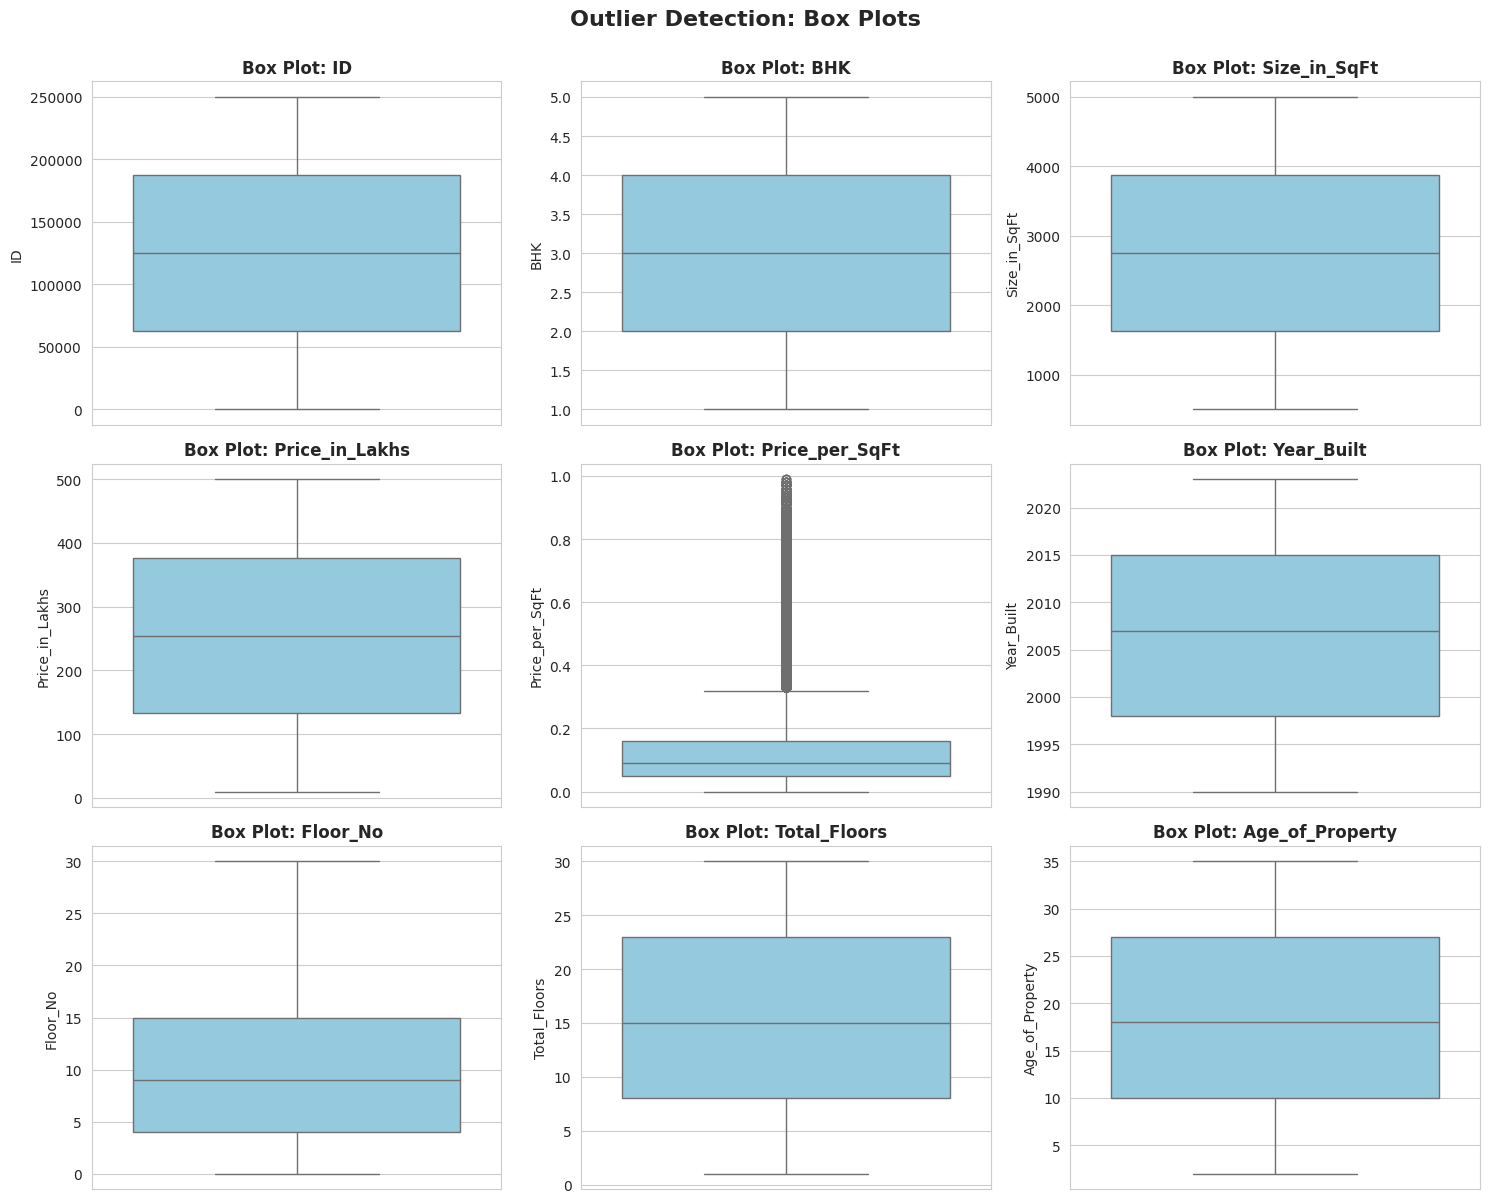


SECTION 5: DISTRIBUTION ANALYSIS


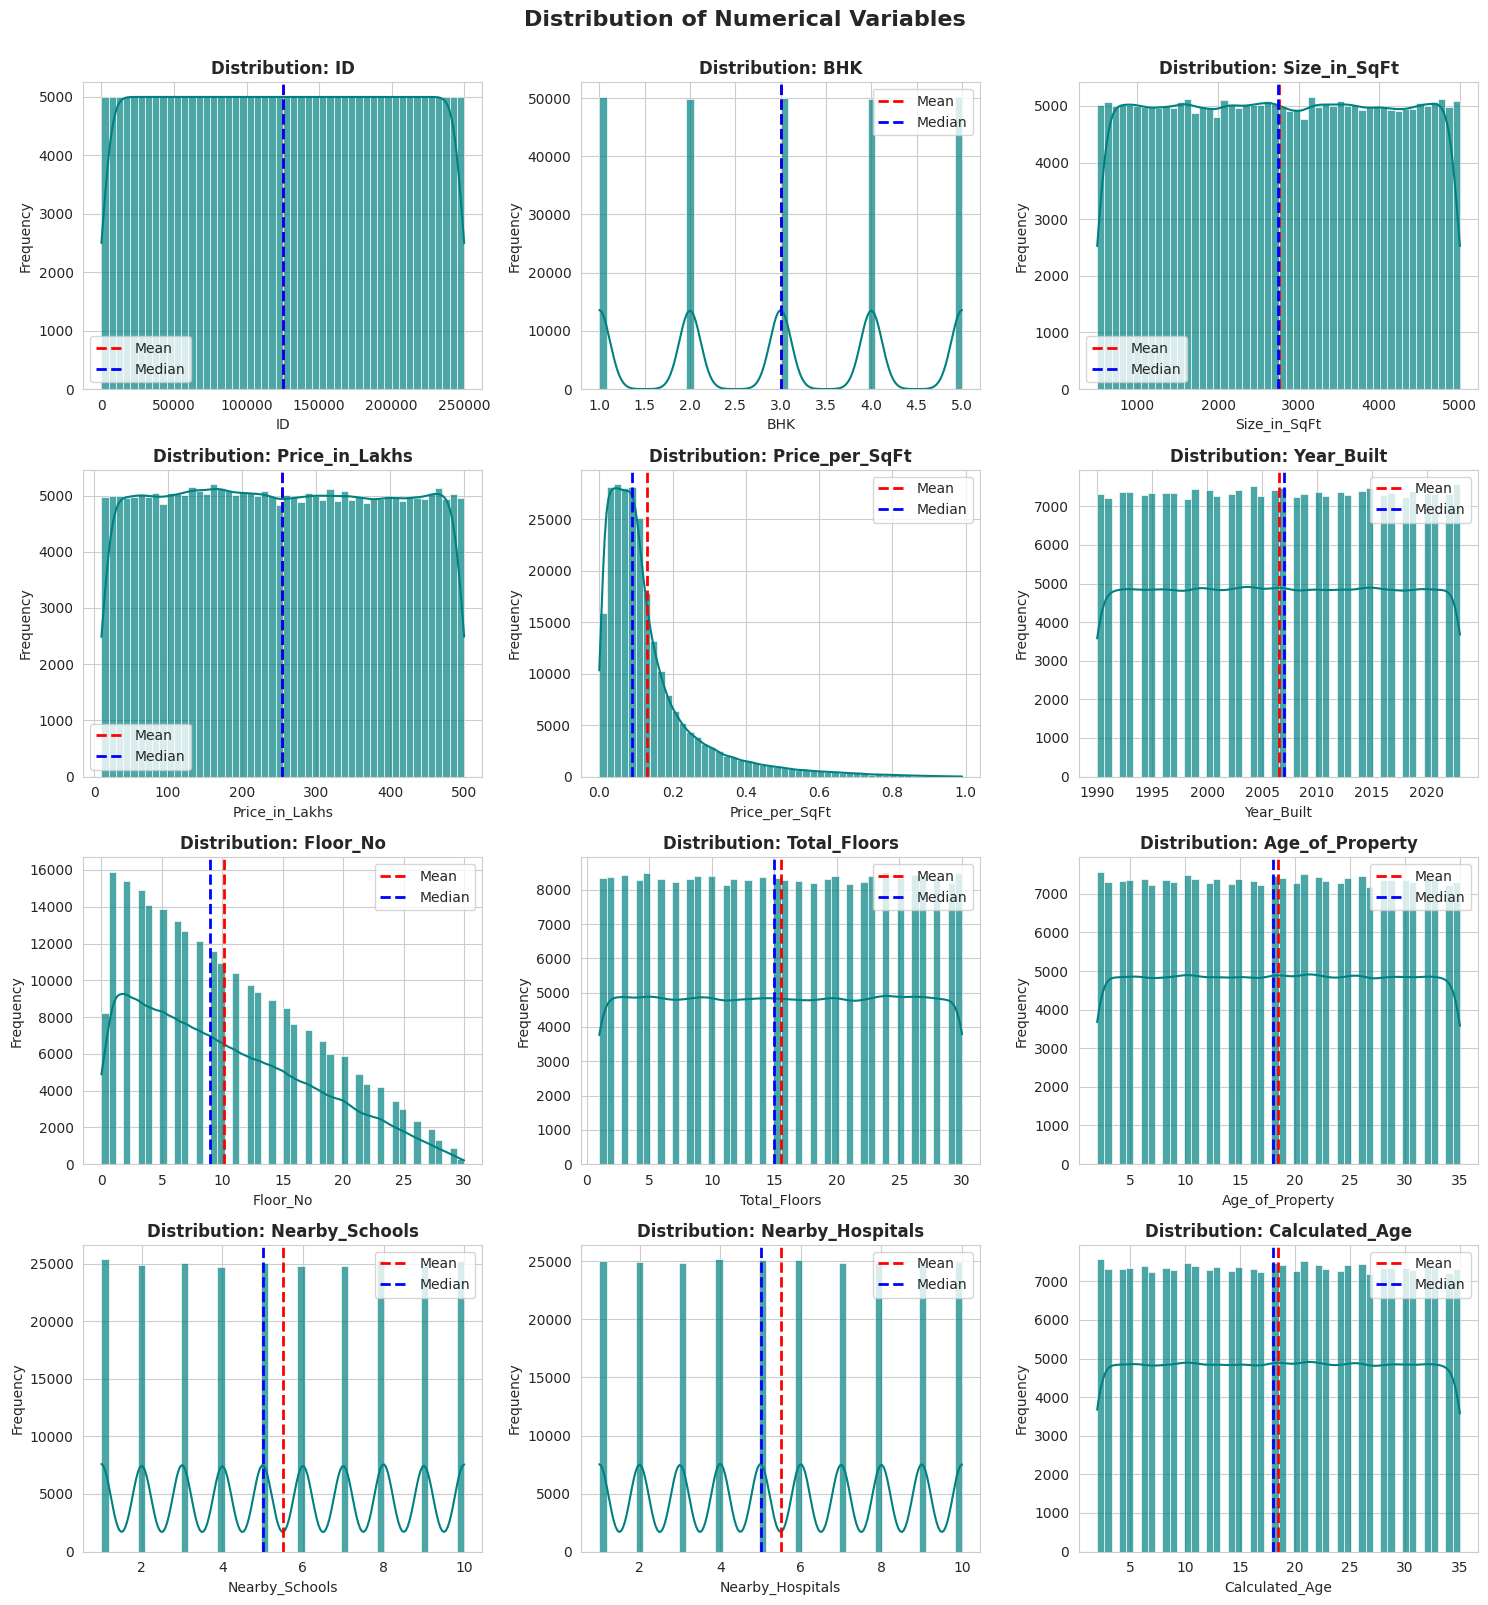


📐 Skewness and Kurtosis:


,Column,Skewness,Kurtosis
0,ID,0.000000,-1.200000
1,BHK,0.000543,-1.301396
2,Size_in_SqFt,0.000796,-1.200308
3,Price_in_Lakhs,0.008206,-1.198798
4,Price_per_SqFt,2.318668,6.708172
5,Year_Built,-0.000167,-1.200191
6,Floor_No,0.568399,-0.588153
7,Total_Floors,-0.000666,-1.207845
8,Age_of_Property,0.000167,-1.200191
9,Nearby_Schools,-0.001258,-1.227825


/tmp/ipython-input-3554998331.py:245: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skew_kurt, x='Skewness', y='Column', ax=axes[0], palette='coolwarm')
/tmp/ipython-input-3554998331.py:250: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=skew_kurt, x='Kurtosis', y='Column', ax=axes[1], palette='coolwarm')


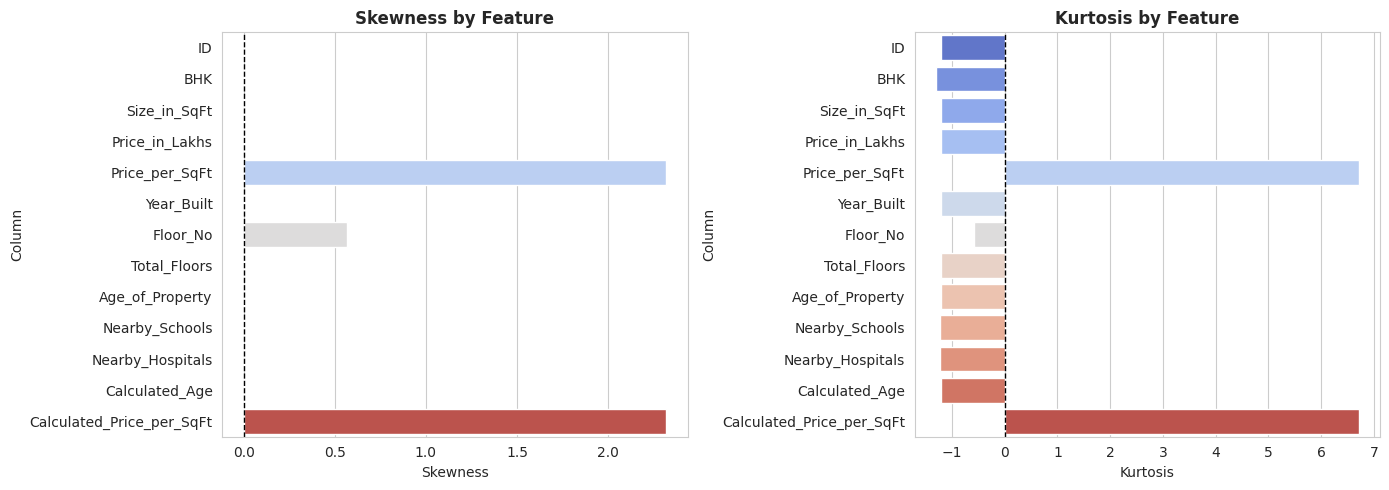

/tmp/ipython-input-3554998331.py:268: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index,
/tmp/ipython-input-3554998331.py:268: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index,
/tmp/ipython-input-3554998331.py:268: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index,
/tmp/ipython-input-3554998331.py:268: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assig

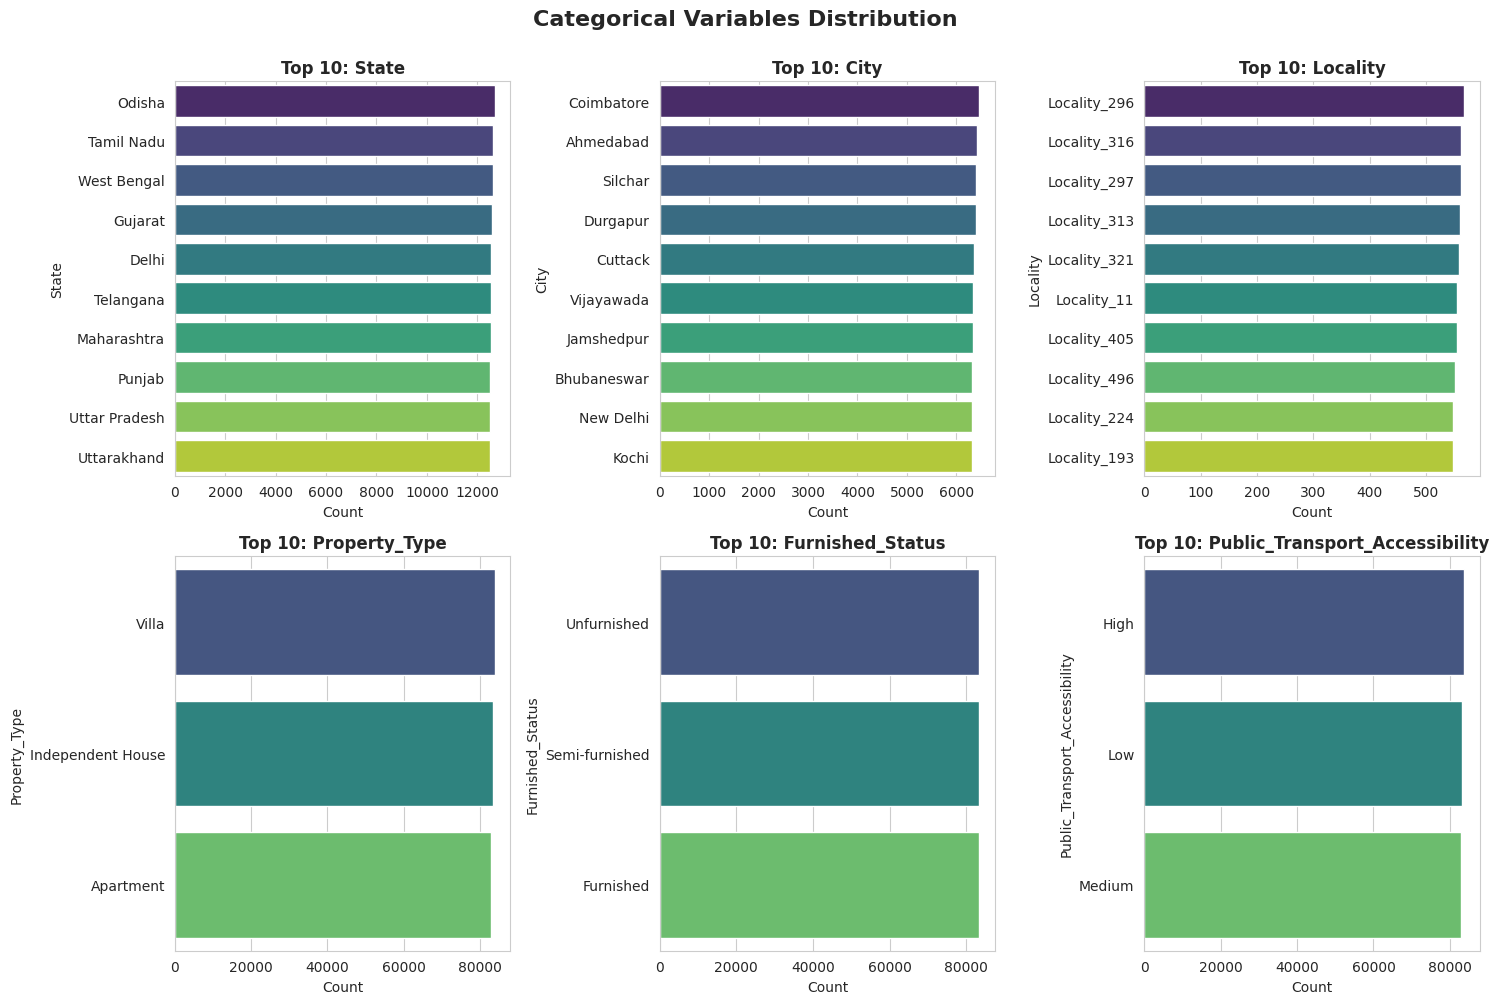


SECTION 6: CORRELATION ANALYSIS

🔗 Correlation Matrix:


,ID,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,Floor_No,Total_Floors,Age_of_Property,Nearby_Schools,Nearby_Hospitals,Calculated_Age,Calculated_Price_per_SqFt
ID,1.000000,-0.001718,-0.002293,-0.001636,-0.001344,0.002734,0.001764,0.003382,-0.002734,-0.001203,0.001429,-0.002734,-0.001328
BHK,-0.001718,1.000000,-0.001033,-0.000980,0.001174,0.000917,-0.001257,-0.002862,-0.000917,-0.000762,0.001162,-0.000917,0.001138
Size_in_SqFt,-0.002293,-0.001033,1.000000,-0.002529,-0.614533,0.004135,-0.003967,-0.003451,-0.004135,0.001966,-0.001695,-0.004135,-0.614610
Price_in_Lakhs,-0.001636,-0.000980,-0.002529,1.000000,0.555625,0.002714,-0.000850,0.001283,-0.002714,0.000155,-0.002769,-0.002714,0.555781
Price_per_SqFt,-0.001344,0.001174,-0.614533,0.555625,1.000000,-0.001212,0.001022,0.004175,0.001212,-0.000094,-0.000145,0.001212,0.999755
Year_Built,0.002734,0.000917,0.004135,0.002714,-0.001212,1.000000,0.002831,0.003452,-1.000000,-0.000591,-0.002719,-1.000000,-0.001330
Floor_No,0.001764,-0.001257,-0.003967,-0.000850,0.001022,0.002831,1.000000,0.582700,-0.002831,-0.001836,-0.001617,-0.002831,0.001016
Total_Floors,0.003382,-0.002862,-0.003451,0.001283,0.004175,0.003452,0.582700,1.000000,-0.003452,-0.003093,-0.005867,-0.003452,0.004161
Age_of_Property,-0.002734,-0.000917,-0.004135,-0.002714,0.001212,-1.000000,-0.002831,-0.003452,1.000000,0.000591,0.002719,1.000000,0.001330
Nearby_Schools,-0.001203,-0.000762,0.001966,0.000155,-0.000094,-0.000591,-0.001836,-0.003093,0.000591,1.000000,-0.002246,0.000591,-0.000058


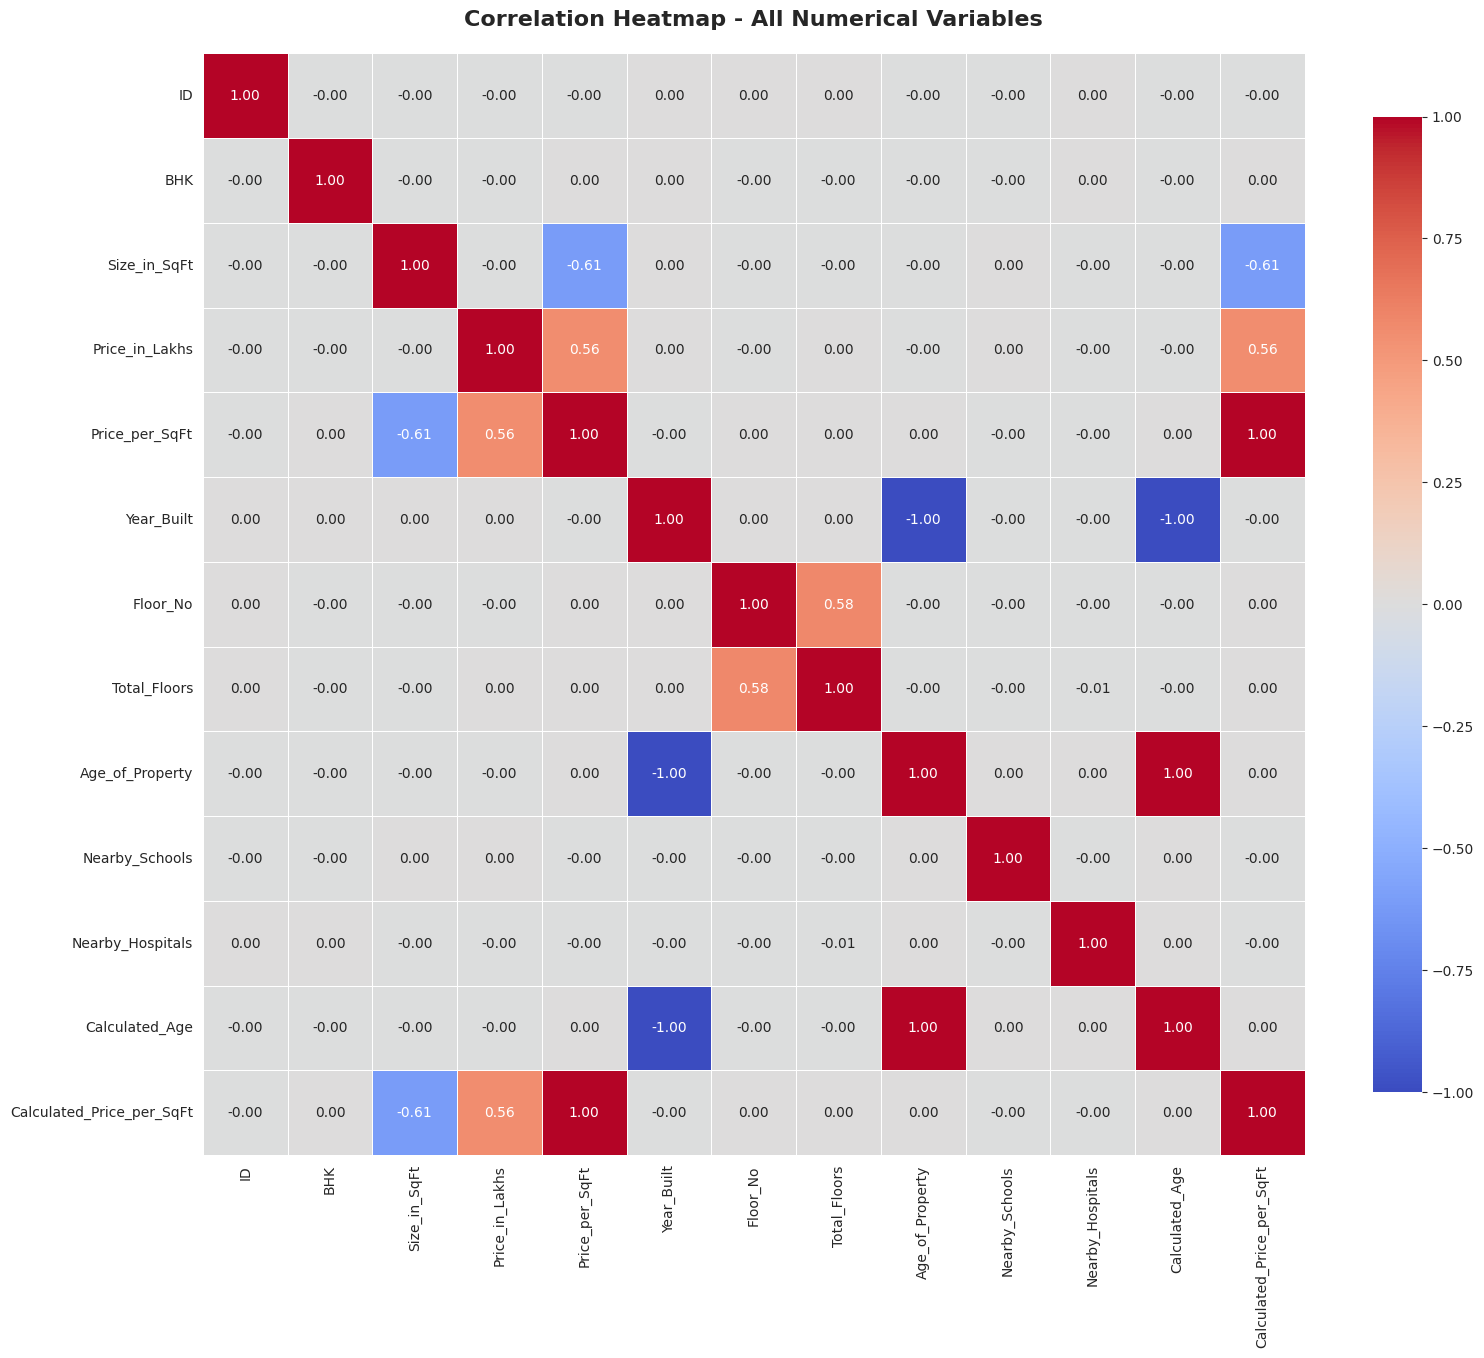


🔥 Highly Correlated Variable Pairs (|r| > 0.7):


,Variable_1,Variable_2,Correlation
3,Age_of_Property,Calculated_Age,1.000000
1,Year_Built,Age_of_Property,-1.000000
2,Year_Built,Calculated_Age,-1.000000
0,Price_per_SqFt,Calculated_Price_per_SqFt,0.999755



SECTION 7: TARGET VARIABLE ANALYSIS

🎯 Target Variable: Price_in_Lakhs
  Mean: 254.59
  Median: 253.87
  Std Dev: 141.35
  Min: 10.00
  Max: 500.00


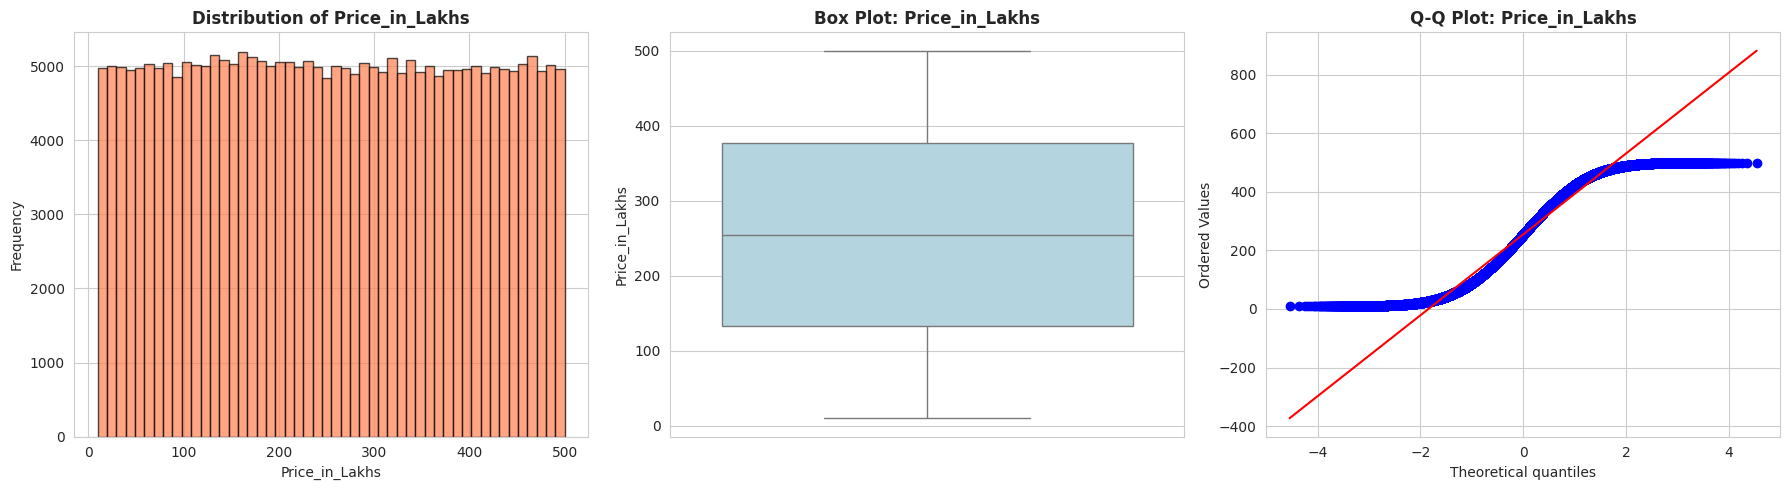


SECTION 8: FEATURE RELATIONSHIPS

📈 Top 5 Features Correlated with Price_in_Lakhs:


,Price_in_Lakhs
Calculated_Price_per_SqFt,0.555781
Price_per_SqFt,0.555625
Year_Built,0.002714
Total_Floors,0.001283
Nearby_Schools,0.000155


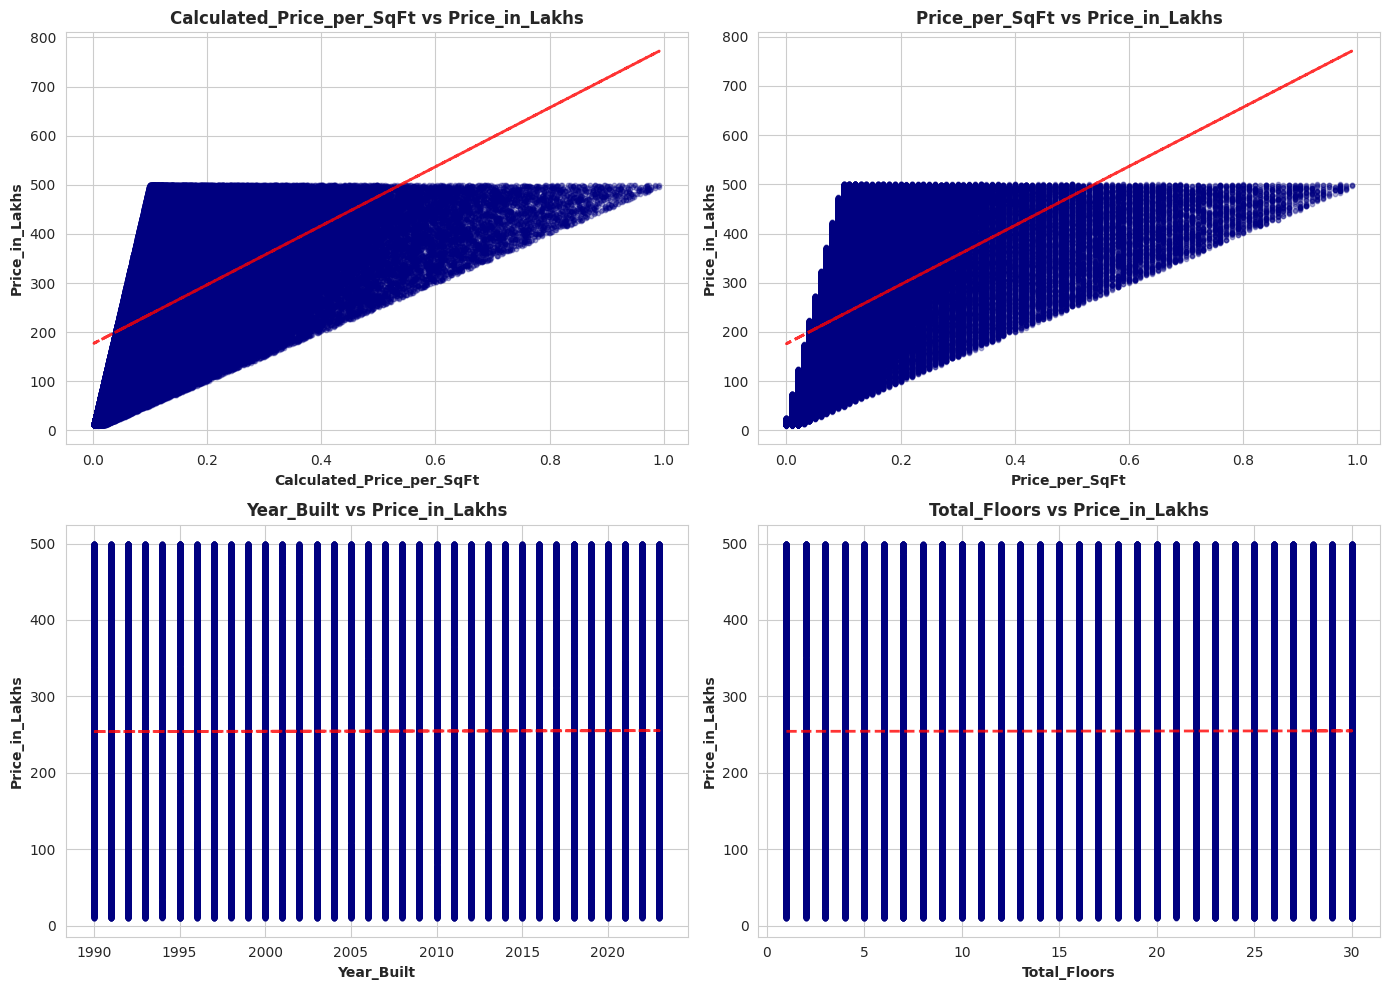


SECTION 9: ADVANCED VISUALIZATIONS

📊 Creating Pairplot (may take a moment)...


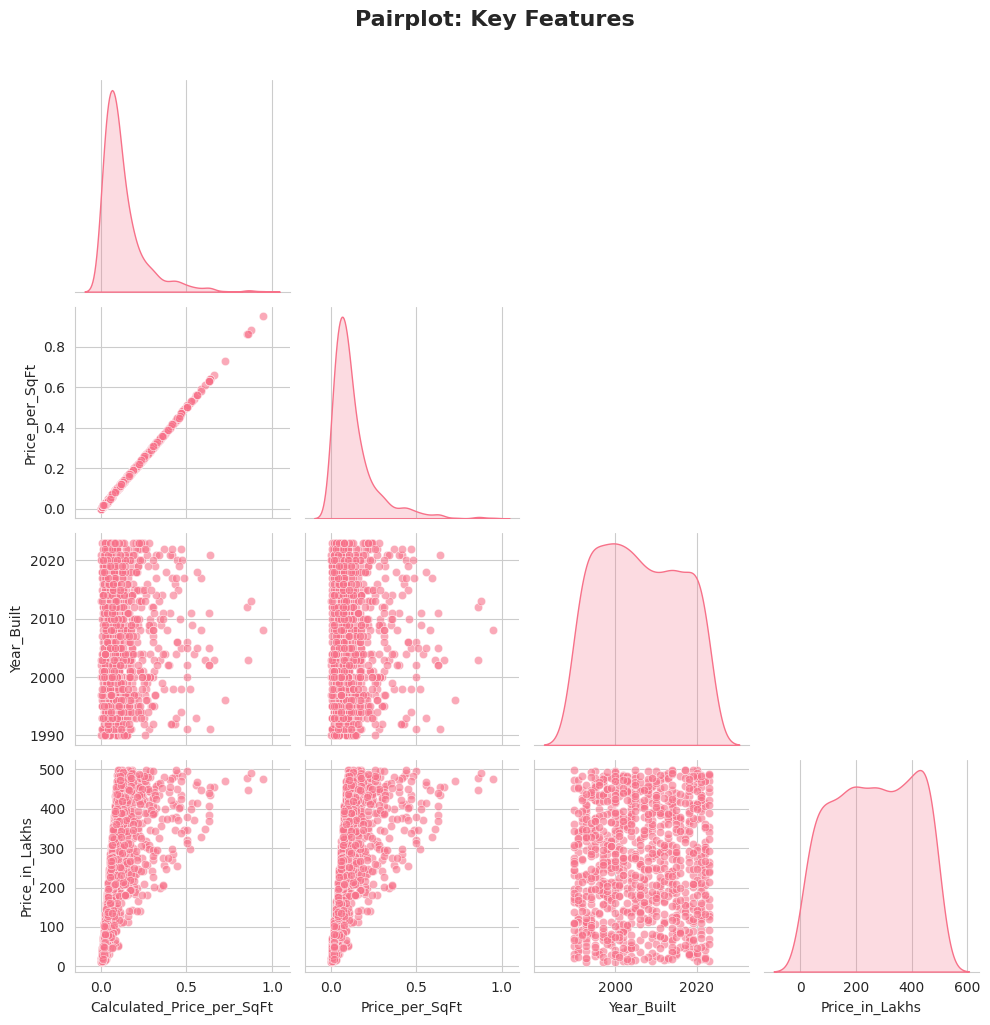


🎻 Creating Violin Plots...


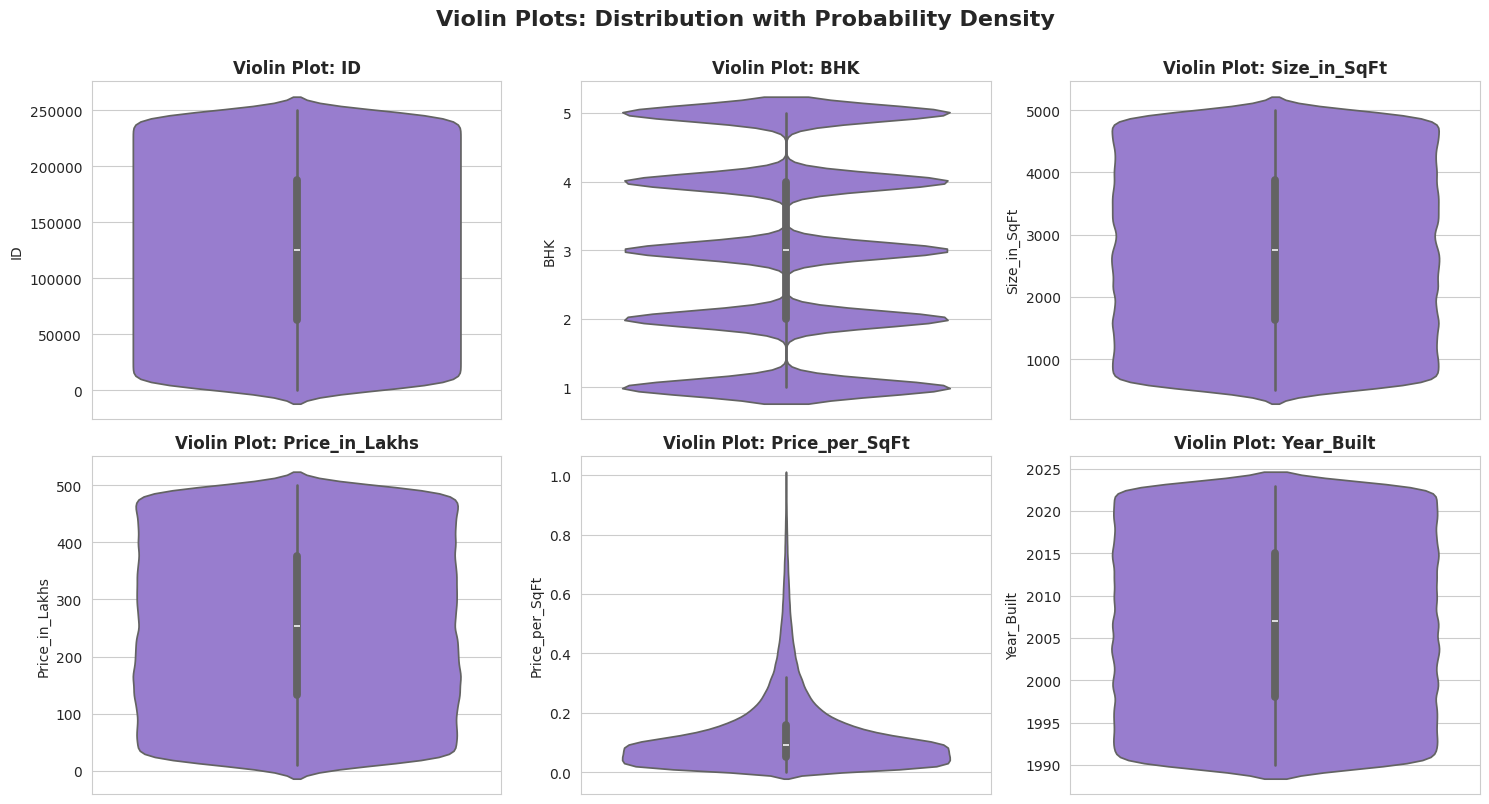


SECTION 10: CATEGORICAL VS TARGET ANALYSIS

📊 Analyzing relationship between categorical variables and Price_in_Lakhs...


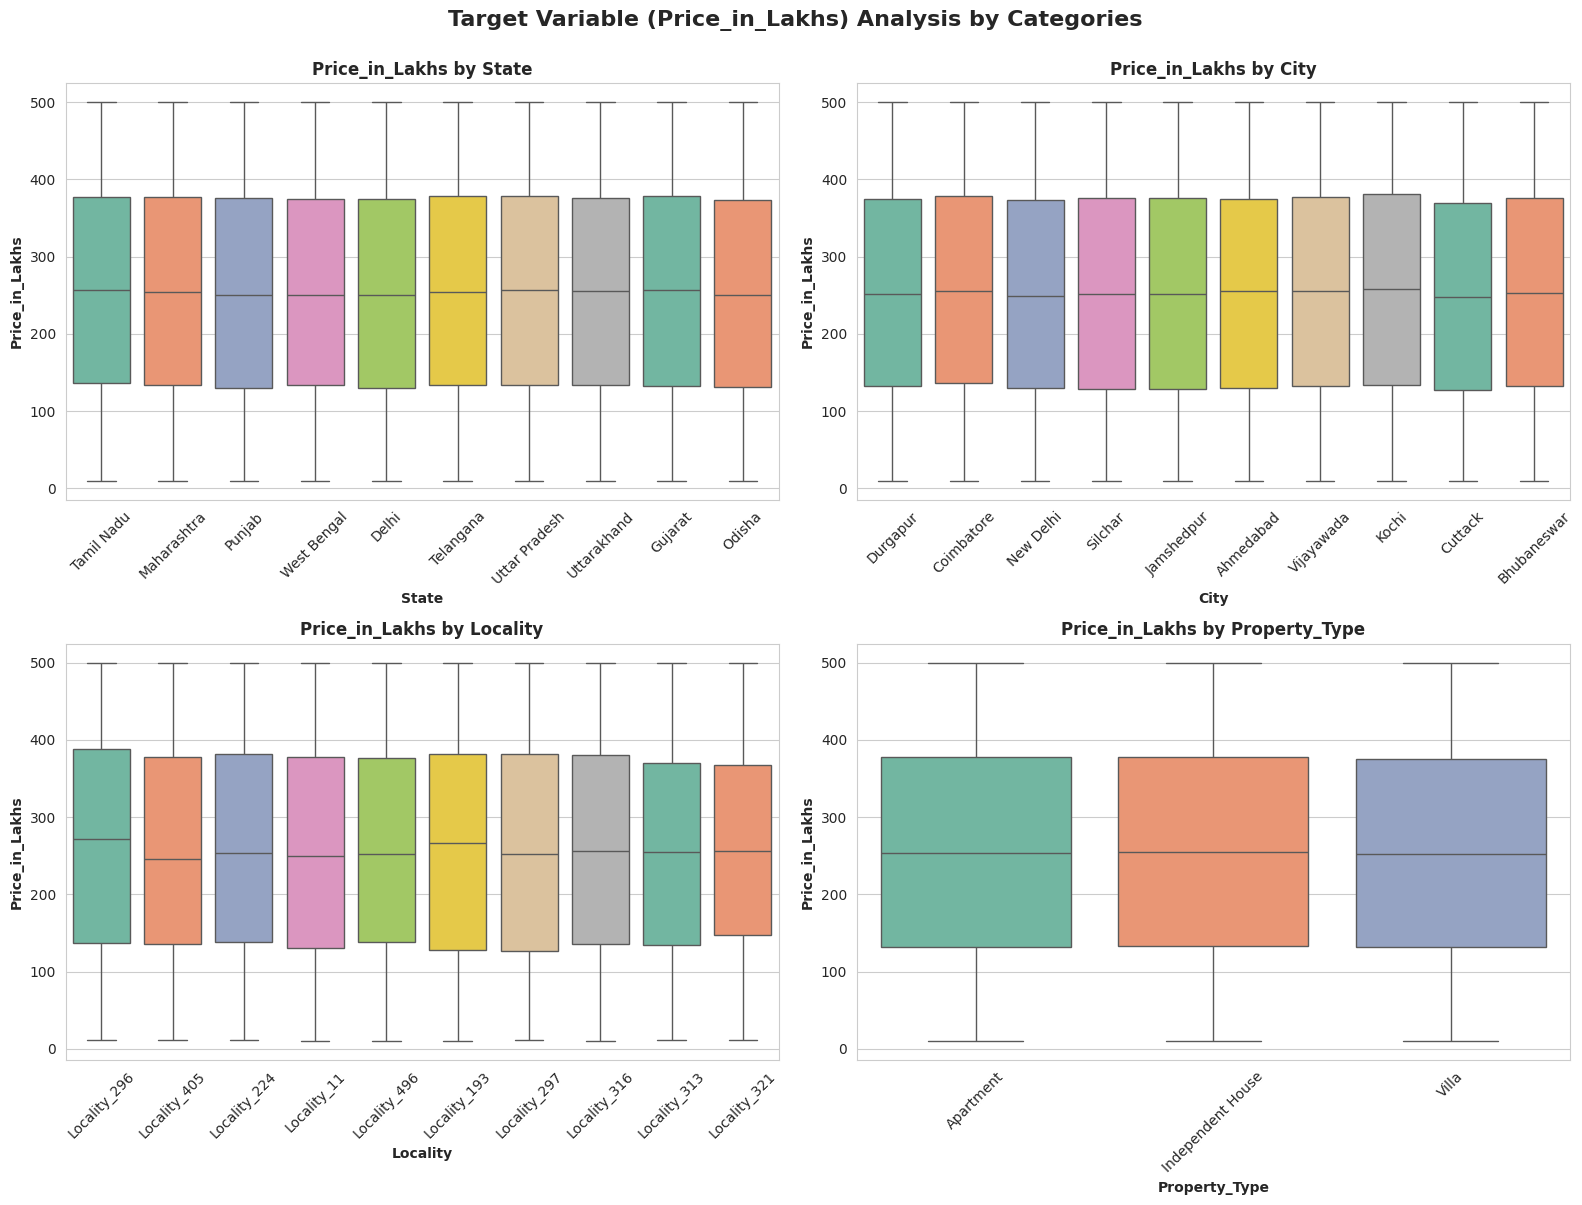


SECTION 11: EDA SUMMARY & KEY INSIGHTS

📋 DATASET SUMMARY:
  • Total Records: 250,000
  • Total Features: 25
  • Numerical Features: 13
  • Categorical Features: 12
  • Missing Values: 0
  • Duplicate Rows: 0
  • Memory Usage: 190.84 MB

🎯 TARGET VARIABLE (Price_in_Lakhs):
  • Mean: 254.59
  • Median: 253.87
  • Range: [10.00, 500.00]
  • Skewness: 0.01

🔥 HIGHLY CORRELATED PAIRS:
  • Found 4 pairs with |correlation| > 0.7


✅ EDA COMPLETE!


In [36]:

# Set visualization styles
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
np.random.seed(42)

# Create a directory for output if it doesn't exist
import os
output_dir = 'eda_outputs'
os.makedirs(output_dir, exist_ok=True)

# ============================================================================
# SECTION 1: BASIC CHARACTERISTICS & STRUCTURE
# Questions 1-2: What are the basic characteristics and structure?
# ============================================================================

print("="*80)
print("SECTION 1: BASIC DATASET CHARACTERISTICS")
print("="*80)

# 1.1 Dataset Shape
print(f"\n📊 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# 1.2 Column Names and Types
print(f"\n📝 Column Names:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col}")

# 1.3 Data Types
print(f"\n🔢 Data Types:")
print(df.dtypes)

# 1.4 Memory Usage
print(f"\n💾 Memory Usage:")
memory_usage = df.memory_usage(deep=True)
print(memory_usage)
total_memory = memory_usage.sum() / 1024**2
print(f"\n⚡ Total Memory: {total_memory:.2f} MB")

# 1.5 First and Last Rows
print(f"\n👀 First 5 Rows:")
display(df.head())

print(f"\n👀 Last 5 Rows:")
display(df.tail())

# 1.6 Random Sample
print(f"\n🎲 Random Sample (5 rows):")
display(df.sample(5, random_state=0))

# 1.7 Variable Classification
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n📈 Numerical Variables ({len(numerical_cols)}):")
print(numerical_cols)

print(f"\n📋 Categorical Variables ({len(categorical_cols)}):")
print(categorical_cols)

# ============================================================================
# SECTION 2: DATA QUALITY ASSESSMENT
# Questions 5-6: Missing values and data correctness
# ============================================================================

print("\n" + "="*80)
print("SECTION 2: DATA QUALITY ASSESSMENT")
print("="*80)

# 2.1 Missing Values Analysis
print("\n❓ Missing Values Analysis:")
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_data) > 0:
    print(missing_data.to_string(index=False))

    # Visualize missing data
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Bar plot of missing percentages
    sns.barplot(data=missing_data, x='Missing_Percentage', y='Column',
                palette='Reds_r', ax=axes[0])
    axes[0].set_title('Missing Data Percentage by Column', fontweight='bold')
    axes[0].set_xlabel('Missing Percentage (%)')
    axes[0].set_ylabel('Column')

    # Heatmap of missing values
    sns.heatmap(df.isnull(), cbar=True, yticklabels=False,
                cmap='viridis', ax=axes[1])
    axes[1].set_title('Missing Data Heatmap', fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("  ✅ No missing values found!")

# 2.2 Duplicate Values
duplicate_count = df.duplicated().sum()
print(f"\n🔄 Duplicate Rows: {duplicate_count:,} ({(duplicate_count/len(df)*100):.2f}%)")

# 2.3 Data Type Verification
print(f"\n✅ Data Type Check:")
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"  {col}: {df[col].dtype} | Unique Values: {unique_count:,}")

# ============================================================================
# SECTION 3: STATISTICAL ANALYSIS
# Question 3: What patterns exist in the data?
# ============================================================================

print("\n" + "="*80)
print("SECTION 3: STATISTICAL ANALYSIS")
print("="*80)

# 3.1 Statistical Summary
print(f"\n📊 Statistical Summary (Numerical Variables):")
display(df.describe())

# 3.2 Statistical Summary for Categorical Variables
if len(categorical_cols) > 0:
    print(f"\n📋 Statistical Summary (Categorical Variables):")
    display(df.describe(include=['object']))

# 3.3 Central Tendency Measures
print(f"\n📍 Central Tendency Measures:")
for col in numerical_cols:
    mode_values = df[col].mode()
    mode_value = mode_values.values[0] if len(mode_values) > 0 else 'N/A'
    print(f"\n{col}:")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Median: {df[col].median():.2f}")
    print(f"  Mode: {mode_value}")

# ============================================================================
# SECTION 4: OUTLIER DETECTION
# Question 4: Are there any outliers present?
# ============================================================================

print("\n" + "="*80)
print("SECTION 4: OUTLIER DETECTION")
print("="*80)

# 4.1 Outlier Detection using IQR Method
def detect_outliers_iqr(data, column):
    """Detect outliers using the IQR method"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

print(f"\n🔍 Outlier Detection (IQR Method):")
outlier_summary = []
for col in numerical_cols[:10]:  # Analyze first 10 numerical columns
    outlier_count, lower, upper = detect_outliers_iqr(df, col)
    outlier_summary.append({
        'Column': col,
        'Outliers': outlier_count,
        'Percentage': (outlier_count/len(df)*100),
        'Lower_Bound': lower,
        'Upper_Bound': upper
    })

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

# 4.2 Box Plots for Outlier Visualization
n_plots = min(9, len(numerical_cols))
n_rows = int(np.ceil(n_plots / 3))
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(numerical_cols[:n_plots]):
    sns.boxplot(data=df, y=col, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Box Plot: {col}', fontweight='bold')
    axes[i].set_ylabel(col)

# Hide unused subplots
for j in range(n_plots, len(axes)):
    axes[j].axis('off')

plt.suptitle('Outlier Detection: Box Plots', y=1.00, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# SECTION 5: DISTRIBUTION ANALYSIS
# Question 10: How much variability exists within each variable?
# ============================================================================

print("\n" + "="*80)
print("SECTION 5: DISTRIBUTION ANALYSIS")
print("="*80)

# 5.1 Distribution Plots for Numerical Variables
n_dist_plots = min(12, len(numerical_cols))
n_rows_dist = int(np.ceil(n_dist_plots / 3))

fig, axes = plt.subplots(n_rows_dist, 3, figsize=(15, n_rows_dist*4))
axes = axes.flatten()

for i, col in enumerate(numerical_cols[:n_dist_plots]):
    # Histogram with KDE
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i], color='teal', alpha=0.7)
    axes[i].axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    axes[i].axvline(df[col].median(), color='blue', linestyle='--', linewidth=2, label='Median')
    axes[i].set_title(f'Distribution: {col}', fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Hide unused subplots
for j in range(n_dist_plots, len(axes)):
    axes[j].axis('off')

plt.suptitle('Distribution of Numerical Variables', y=1.00, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 5.2 Skewness and Kurtosis
print(f"\n📐 Skewness and Kurtosis:")
skew_kurt = pd.DataFrame({
    'Column': numerical_cols,
    'Skewness': [df[col].skew() for col in numerical_cols],
    'Kurtosis': [df[col].kurtosis() for col in numerical_cols]
})
display(skew_kurt)

# Visualize Skewness and Kurtosis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=skew_kurt, x='Skewness', y='Column', ax=axes[0], palette='coolwarm')
axes[0].axvline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('Skewness by Feature', fontweight='bold')
axes[0].set_xlabel('Skewness')

sns.barplot(data=skew_kurt, x='Kurtosis', y='Column', ax=axes[1], palette='coolwarm')
axes[1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Kurtosis by Feature', fontweight='bold')
axes[1].set_xlabel('Kurtosis')

plt.tight_layout()
plt.show()

# 5.3 Count Plots for Categorical Variables
if len(categorical_cols) > 0:
    n_cat = min(6, len(categorical_cols))
    n_rows_cat = int(np.ceil(n_cat / 3))

    fig, axes = plt.subplots(n_rows_cat, 3, figsize=(15, n_rows_cat*5))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols[:n_cat]):
        top_categories = df[col].value_counts().head(10)
        sns.barplot(x=top_categories.values, y=top_categories.index,
                   ax=axes[i], palette='viridis')
        axes[i].set_title(f'Top 10: {col}', fontweight='bold')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(col)

    # Hide unused subplots
    for j in range(n_cat, len(axes)):
        axes[j].axis('off')

    plt.suptitle('Categorical Variables Distribution', y=1.00, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ============================================================================
# SECTION 6: CORRELATION ANALYSIS
# Question 7: Is there any correlation between variables?
# ============================================================================

print("\n" + "="*80)
print("SECTION 6: CORRELATION ANALYSIS")
print("="*80)

# 6.1 Correlation Matrix
correlation_matrix = df[numerical_cols].corr()
print(f"\n🔗 Correlation Matrix:")
display(correlation_matrix)

# 6.2 Correlation Heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - All Numerical Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'correlation_heatmap.png')) # Save plot
plt.show()
plt.close() # Close figure to free memory

# 6.3 Highly Correlated Variables
print(f"\n🔥 Highly Correlated Variable Pairs (|r| > 0.7):")
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'Variable_1': correlation_matrix.columns[i],
                'Variable_2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr:
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', key=abs, ascending=False)
    display(high_corr_df)
else:
    print("  ✅ No highly correlated pairs found (|r| > 0.7)")

# ============================================================================
# SECTION 7: TARGET VARIABLE ANALYSIS
# Question 3: What patterns exist in the data?
# ============================================================================

print("\n" + "="*80)
print("SECTION 7: TARGET VARIABLE ANALYSIS")
print("="*80)

# Identify target variable
target_col = 'Price_in_Lakhs' if 'Price_in_Lakhs' in df.columns else numerical_cols[0]

print(f"\n🎯 Target Variable: {target_col}")
print(f"  Mean: {df[target_col].mean():.2f}")
print(f"  Median: {df[target_col].median():.2f}")
print(f"  Std Dev: {df[target_col].std():.2f}")
print(f"  Min: {df[target_col].min():.2f}")
print(f"  Max: {df[target_col].max():.2f}")

# Target distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df[target_col].dropna(), bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_title(f'Distribution of {target_col}', fontweight='bold')
axes[0].set_xlabel(target_col)
axes[0].set_ylabel('Frequency')

# Box plot
sns.boxplot(data=df, y=target_col, ax=axes[1], color='lightblue')
axes[1].set_title(f'Box Plot: {target_col}', fontweight='bold')
axes[1].set_ylabel(target_col)

# Q-Q plot
stats.probplot(df[target_col].dropna(), dist="norm", plot=axes[2])
axes[2].set_title(f'Q-Q Plot: {target_col}', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'target_distribution.png')) # Save plot
plt.show()
plt.close() # Close figure to free memory

# ============================================================================
# SECTION 8: SCATTER PLOTS & RELATIONSHIPS
# Question 3: What patterns exist? Question 7: Correlations?
# ============================================================================

print("\n" + "="*80)
print("SECTION 8: FEATURE RELATIONSHIPS")
print("="*80)

# Check if target column exists in correlation matrix
if target_col in correlation_matrix.columns:
    # Top correlated features with target
    target_correlations = correlation_matrix[target_col].sort_values(ascending=False)[1:6]
    print(f"\n📈 Top 5 Features Correlated with {target_col}:")
    display(target_correlations)

    # Scatter plots
    n_scatter = min(4, len(target_correlations))

    if n_scatter > 0:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()

        for i, feature in enumerate(target_correlations.index[:n_scatter]):
            axes[i].scatter(df[feature], df[target_col], alpha=0.3, color='navy', s=10)
            axes[i].set_xlabel(feature, fontweight='bold')
            axes[i].set_ylabel(target_col, fontweight='bold')
            axes[i].set_title(f'{feature} vs {target_col}', fontweight='bold')

            # Add regression line
            z = np.polyfit(df[feature].dropna(), df[target_col].dropna(), 1)
            p = np.poly1d(z)
            axes[i].plot(df[feature], p(df[feature]), "r--", alpha=0.8, linewidth=2)

        # Hide unused subplots
        for j in range(n_scatter, 4):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Not enough correlated features for scatter plots")
else:
    print(f"⚠️ Warning: {target_col} not found in correlation matrix")
    target_correlations = pd.Series()

# ============================================================================
# SECTION 9: ADVANCED VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("SECTION 9: ADVANCED VISUALIZATIONS")
print("="*80)

# 9.1 Pairplot (subset of features)
if len(target_correlations) >= 3:
    print("\n📊 Creating Pairplot (may take a moment)...")
    key_features = target_correlations.index[:3].tolist() + [target_col]
    sample_size = min(1000, len(df))

    pairplot_data = df[key_features].sample(sample_size, random_state=42)
    g = sns.pairplot(pairplot_data, diag_kind='kde', corner=True, plot_kws={'alpha': 0.6})
    g.fig.suptitle('Pairplot: Key Features', y=1.02, fontsize=16, fontweight='bold') # Use g.fig for pairplot suptitle
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'pairplot_key_features.png')) # Save pairplot
    plt.show()
    plt.close() # Close figure to free memory
else:
    print("⚠️ Not enough features for pairplot (need at least 3)")

# 9.2 Violin Plots for Top Numerical Features
print("\n🎻 Creating Violin Plots...")
top_features = numerical_cols[:6]
n_violin = len(top_features)
n_rows_violin = int(np.ceil(n_violin / 3))

fig, axes = plt.subplots(n_rows_violin, 3, figsize=(15, n_rows_violin*4))
axes = axes.flatten()

for i, col in enumerate(top_features):
    sns.violinplot(data=df, y=col, ax=axes[i], color='mediumpurple')
    axes[i].set_title(f'Violin Plot: {col}', fontweight='bold')
    axes[i].set_ylabel(col)

# Hide unused subplots
for j in range(n_violin, len(axes)):
    axes[j].axis('off')

plt.suptitle('Violin Plots: Distribution with Probability Density', y=1.00, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
plt.close() # Close figure to free memory

# ============================================================================
# SECTION 10: CATEGORICAL VS TARGET ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SECTION 10: CATEGORICAL VS TARGET ANALYSIS")
print("="*80)

if len(categorical_cols) > 0 and target_col in df.columns:
    print(f"\n📊 Analyzing relationship between categorical variables and {target_col}...")

    n_cat_analysis = min(4, len(categorical_cols))

    if n_cat_analysis > 0:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()

        for i, cat_col in enumerate(categorical_cols[:n_cat_analysis]):
            # Get top 10 categories
            top_cats = df[cat_col].value_counts().head(10).index
            filtered_df = df[df[cat_col].isin(top_cats)]

            # Fixed: Assign hue parameter to match x
            sns.boxplot(data=filtered_df, x=cat_col, y=target_col,
                       hue=cat_col, palette='Set2', legend=False, ax=axes[i])
            axes[i].set_title(f'{target_col} by {cat_col}', fontweight='bold', fontsize=12)
            axes[i].set_xlabel(cat_col, fontweight='bold')
            axes[i].set_ylabel(target_col, fontweight='bold')
            axes[i].tick_params(axis='x', rotation=45)

        # Hide unused subplots
        for j in range(n_cat_analysis, 4):
            axes[j].axis('off')

        plt.suptitle(f'Target Variable ({target_col}) Analysis by Categories',
                     y=1.00, fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'categorical_vs_target.png')) # Save plot
        plt.show()
        plt.close() # Close figure to free memory
    else:
        print("⚠️ No categorical variables to analyze")
else:
    print("⚠️ Either no categorical variables or target column not found")


# ============================================================================
# SECTION 11: SUMMARY & KEY INSIGHTS
# ============================================================================

print("\n" + "="*80)
print("SECTION 11: EDA SUMMARY & KEY INSIGHTS")
print("="*80)

summary_text = f"""
📋 DATASET SUMMARY:
  • Total Records: {len(df):,}
  • Total Features: {len(df.columns)}
  • Numerical Features: {len(numerical_cols)}
  • Categorical Features: {len(categorical_cols)}
  • Missing Values: {df.isnull().sum().sum():,}
  • Duplicate Rows: {duplicate_count:,}
  • Memory Usage: {total_memory:.2f} MB

🎯 TARGET VARIABLE ({target_col}):
  • Mean: {df[target_col].mean():.2f}
  • Median: {df[target_col].median():.2f}
  • Range: [{df[target_col].min():.2f}, {df[target_col].max():.2f}]
  • Skewness: {df[target_col].skew():.2f}
"""

if len(high_corr) > 0:
    summary_text += f"\n🔥 HIGHLY CORRELATED PAIRS:\n  • Found {len(high_corr)} pairs with |correlation| > 0.7\n"
else:
    summary_text += f"\n✅ No highly correlated pairs found (|r| > 0.7)"

summary_text += f"\n\n✅ EDA COMPLETE!\n" + "="*80

print(summary_text)

# Save summary to a text file
with open(os.path.join(output_dir, 'eda_summary.txt'), 'w') as f:
    f.write(summary_text)


In [37]:
# ============================================================================
# COMPREHENSIVE DATA QUALITY VALIDATION
# ============================================================================

print("="*80)
print("COMPREHENSIVE DATA QUALITY CHECK")
print("="*80)

# ----------------------------------------------------------------------------
# 1. CHECK FOR PLACEHOLDER/SENTINEL VALUES
# ----------------------------------------------------------------------------
print("\n🔍 Step 1: Checking for placeholder values...")

placeholder_values = [0, -1, 9999, 99999, -999, 'Unknown', 'NA', 'N/A', 'None', '']
issues = []

for col in df.columns:
    for placeholder in placeholder_values:
        if df[col].dtype in ['int64', 'float64']:
            if placeholder in df[col].values:
                count = (df[col] == placeholder).sum()
                if count > 0:
                    issues.append(f"  ⚠️ {col}: Found {count:,} rows with value {placeholder}")
        elif df[col].dtype == 'object':
            if placeholder in df[col].values:
                count = (df[col] == placeholder).sum()
                if count > 0:
                    issues.append(f"  ⚠️ {col}: Found {count:,} rows with value '{placeholder}'")

if issues:
    for issue in issues:
        print(issue)
else:
    print("  ✅ No obvious placeholder values found")

# ----------------------------------------------------------------------------
# 2. CHECK FOR LOGICAL INCONSISTENCIES
# ----------------------------------------------------------------------------
print("\n🔍 Step 2: Checking for logical inconsistencies...")

# Example checks (adjust based on your columns)
inconsistencies = []

# Check: Bedrooms should be reasonable
if 'BHK' in df.columns:
    unrealistic_bhk = df[df['BHK'] > 20]
    if len(unrealistic_bhk) > 0:
        inconsistencies.append(f"  ⚠️ Found {len(unrealistic_bhk)} properties with >20 BHK")

# Check: Size cannot be zero or negative
if 'Size_in_SqFt' in df.columns:
    invalid_size = df[df['Size_in_SqFt'] <= 0]
    if len(invalid_size) > 0:
        inconsistencies.append(f"  ⚠️ Found {len(invalid_size)} properties with Size ≤ 0")

# Check: Price cannot be zero
if 'Price_in_Lakhs' in df.columns:
    zero_price = df[df['Price_in_Lakhs'] <= 0]
    if len(zero_price) > 0:
        inconsistencies.append(f"  ⚠️ Found {len(zero_price)} properties with Price ≤ 0")

# Check: Price per sqft should be reasonable
if 'Price_per_SqFt' in df.columns:
    # Assuming reasonable range is 1000-50000 per sqft
    unrealistic_price_sqft = df[(df['Price_per_SqFt'] < 100) | (df['Price_per_SqFt'] > 100000)]
    if len(unrealistic_price_sqft) > 0:
        inconsistencies.append(f"  ⚠️ Found {len(unrealistic_price_sqft)} properties with unrealistic price/sqft")

# Check: Year built should be reasonable
if 'Year_Built' in df.columns:
    future_year = df[df['Year_Built'] > 2026]
    old_year = df[df['Year_Built'] < 1900]
    if len(future_year) > 0:
        inconsistencies.append(f"  ⚠️ Found {len(future_year)} properties built in future")
    if len(old_year) > 0:
        inconsistencies.append(f"  ⚠️ Found {len(old_year)} properties built before 1900")

if inconsistencies:
    for issue in inconsistencies:
        print(issue)
else:
    print("  ✅ No logical inconsistencies found")

# ----------------------------------------------------------------------------
# 3. CHECK FOR WHITESPACE AND FORMATTING ISSUES
# ----------------------------------------------------------------------------
print("\n🔍 Step 3: Checking for string formatting issues...")

string_issues = []
for col in df.select_dtypes(include=['object']).columns:
    # Check for leading/trailing spaces
    has_spaces = df[col].astype(str).str.strip() != df[col].astype(str)
    if has_spaces.sum() > 0:
        string_issues.append(f"  ⚠️ {col}: {has_spaces.sum()} values have leading/trailing spaces")

    # Check for mixed case (if it should be consistent)
    unique_values = df[col].nunique()
    unique_lower = df[col].str.lower().nunique()
    if unique_values != unique_lower:
        string_issues.append(f"  ⚠️ {col}: Has case sensitivity issues ({unique_values} vs {unique_lower} unique)")

if string_issues:
    for issue in string_issues[:10]:  # Show first 10
        print(issue)
else:
    print("  ✅ No string formatting issues found")

# ----------------------------------------------------------------------------
# 4. CHECK DATA TYPE APPROPRIATENESS
# ----------------------------------------------------------------------------
print("\n🔍 Step 4: Checking data type appropriateness...")

dtype_issues = []

# Check if numeric columns are actually numeric
for col in numerical_cols:
    if df[col].dtype == 'object':
        dtype_issues.append(f"  ⚠️ {col}: Should be numeric but is 'object' type")

# Check if categorical columns with few unique values should be category type
for col in categorical_cols:
    unique_count = df[col].nunique()
    if unique_count < 50 and df[col].dtype != 'category':
        dtype_issues.append(f"  💡 {col}: Could be optimized to 'category' type ({unique_count} unique values)")

if dtype_issues:
    for issue in dtype_issues:
        print(issue)
else:
    print("  ✅ Data types are appropriate")

# ----------------------------------------------------------------------------
# 5. CHECK VALUE RANGES
# ----------------------------------------------------------------------------
print("\n🔍 Step 5: Checking value ranges for all numerical columns...")

print("\nNumerical Column Ranges:")
for col in numerical_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    mean_val = df[col].mean()
    print(f"  {col}:")
    print(f"    Min: {min_val:,.2f} | Max: {max_val:,.2f} | Mean: {mean_val:,.2f}")

    # Flag if min is suspicious
    if min_val < 0 and col not in ['Latitude', 'Longitude']:
        print(f"    ⚠️ WARNING: Negative values found!")
    if min_val == 0 and 'Price' in col:
        print(f"    ⚠️ WARNING: Zero values found in price column!")

# ----------------------------------------------------------------------------
# 6. CHECK CATEGORICAL VALUE CONSISTENCY
# ----------------------------------------------------------------------------
print("\n🔍 Step 6: Checking categorical value consistency...")

print("\nCategorical Column Value Counts:")
for col in categorical_cols[:5]:  # Check first 5
    print(f"\n{col} (Top 10 values):")
    value_counts = df[col].value_counts().head(10)
    for val, count in value_counts.items():
        print(f"  {val}: {count:,} ({count/len(df)*100:.2f}%)")

# ----------------------------------------------------------------------------
# 7. CHECK FOR OUTLIERS (More Detailed)
# ----------------------------------------------------------------------------
print("\n🔍 Step 7: Detailed outlier analysis...")

def advanced_outlier_check(data, column):
    """Check outliers using multiple methods"""
    # IQR method
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR
    iqr_outliers = ((data[column] < lower_iqr) | (data[column] > upper_iqr)).sum()

    # Z-score method (values beyond 3 std dev)
    z_scores = np.abs(stats.zscore(data[column].dropna()))
    z_outliers = (z_scores > 3).sum()

    return {
        'IQR_outliers': iqr_outliers,
        'Z_score_outliers': z_outliers,
        'IQR_percentage': (iqr_outliers / len(data)) * 100,
        'Z_percentage': (z_outliers / len(data)) * 100
    }

print("\nOutlier Summary (First 5 numerical columns):")
for col in numerical_cols[:5]:
    outlier_stats = advanced_outlier_check(df, col)
    print(f"\n{col}:")
    print(f"  IQR Method: {outlier_stats['IQR_outliers']:,} ({outlier_stats['IQR_percentage']:.2f}%)")
    print(f"  Z-Score Method: {outlier_stats['Z_score_outliers']:,} ({outlier_stats['Z_percentage']:.2f}%)")

# ----------------------------------------------------------------------------
# FINAL VERDICT
# ----------------------------------------------------------------------------
print("\n" + "="*80)
print("DATA QUALITY VERDICT")
print("="*80)

total_issues = len(issues) + len(inconsistencies) + len(string_issues) + len(dtype_issues)

if total_issues == 0:
    print("\n✅ DATA IS CLEAN!")
    print("   • No placeholder values")
    print("   • No logical inconsistencies")
    print("   • No formatting issues")
    print("   • Appropriate data types")
    print("\n🎉 Ready for Feature Engineering!")
else:
    print(f"\n⚠️ FOUND {total_issues} POTENTIAL ISSUES")
    print("   Please review and clean before proceeding to Day 2")
    print("\n📝 Recommended actions:")
    print("   1. Review flagged issues above")
    print("   2. Decide on cleaning strategy for each")
    print("   3. Apply cleaning transformations")
    print("   4. Re-run validation")


COMPREHENSIVE DATA QUALITY CHECK

🔍 Step 1: Checking for placeholder values...
  ⚠️ ID: Found 1 rows with value 9999
  ⚠️ ID: Found 1 rows with value 99999
  ⚠️ Price_per_SqFt: Found 2,534 rows with value 0
  ⚠️ Floor_No: Found 8,203 rows with value 0

🔍 Step 2: Checking for logical inconsistencies...
  ⚠️ Found 250000 properties with unrealistic price/sqft

🔍 Step 3: Checking for string formatting issues...
  ✅ No string formatting issues found

🔍 Step 4: Checking data type appropriateness...
  💡 State: Could be optimized to 'category' type (20 unique values)
  💡 City: Could be optimized to 'category' type (42 unique values)
  💡 Property_Type: Could be optimized to 'category' type (3 unique values)
  💡 Furnished_Status: Could be optimized to 'category' type (3 unique values)
  💡 Public_Transport_Accessibility: Could be optimized to 'category' type (3 unique values)
  💡 Parking_Space: Could be optimized to 'category' type (2 unique values)
  💡 Security: Could be optimized to 'category'

In [38]:
# ============================================================================
# DATA CLEANING - CORRECTED APPROACH
# ============================================================================

print("="*80)
print("DATA CLEANING IN PROGRESS")
print("="*80)

# Create a copy
df_cleaned = df.copy()
print(f"\n📊 Original Shape: {df_cleaned.shape}")

# ----------------------------------------------------------------------------
# FIX 1: REMOVE ROWS WITH ZERO Price_per_SqFt (Invalid Data)
# ----------------------------------------------------------------------------
print("\n🔧 Fix 1: Removing rows with zero Price_per_SqFt...")

zero_price_sqft = (df_cleaned['Price_per_SqFt'] == 0).sum()
print(f"  📊 Found {zero_price_sqft:,} rows with Price_per_SqFt = 0")

# Remove these invalid rows
df_cleaned = df_cleaned[df_cleaned['Price_per_SqFt'] > 0]

removed = zero_price_sqft
print(f"  ✅ Removed {removed:,} rows with invalid (zero) Price_per_SqFt")

# Verify Price_per_SqFt range after removal
print(f"\n📊 Price_per_SqFt range after cleaning:")
print(f"  Min: ₹{df_cleaned['Price_per_SqFt'].min():.4f} Lakhs/sqft (₹{df_cleaned['Price_per_SqFt'].min()*100000:,.0f} per sqft)")
print(f"  Max: ₹{df_cleaned['Price_per_SqFt'].max():.4f} Lakhs/sqft (₹{df_cleaned['Price_per_SqFt'].max()*100000:,.0f} per sqft)")
print(f"  Mean: ₹{df_cleaned['Price_per_SqFt'].mean():.4f} Lakhs/sqft (₹{df_cleaned['Price_per_SqFt'].mean()*100000:,.0f} per sqft)")

# ----------------------------------------------------------------------------
# FIX 2: OPTIMIZE CATEGORICAL DATATYPES (Memory Efficiency)
# ----------------------------------------------------------------------------
print("\n🔧 Fix 2: Optimizing categorical column datatypes...")

categorical_to_optimize = [
    'State', 'City', 'Property_Type', 'Furnished_Status',
    'Public_Transport_Accessibility', 'Parking_Space',
    'Security', 'Facing', 'Owner_Type', 'Availability_Status'
]

memory_before = df_cleaned.memory_usage(deep=True).sum() / 1024**2

for col in categorical_to_optimize:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].astype('category')

memory_after = df_cleaned.memory_usage(deep=True).sum() / 1024**2
memory_saved = memory_before - memory_after

print(f"  ✅ Converted {len(categorical_to_optimize)} columns to 'category' dtype")
print(f"  💾 Memory saved: {memory_saved:.2f} MB ({memory_before:.2f} → {memory_after:.2f} MB)")

# ----------------------------------------------------------------------------
# FIX 3: VERIFY DATA INTEGRITY
# ----------------------------------------------------------------------------
print("\n🔧 Fix 3: Final data integrity checks...")

# Check for any remaining issues
print(f"\n✅ Integrity Checks:")

# 1. No negative values in key columns
negative_checks = {
    'Price_in_Lakhs': (df_cleaned['Price_in_Lakhs'] < 0).sum(),
    'Size_in_SqFt': (df_cleaned['Size_in_SqFt'] <= 0).sum(),
    'Price_per_SqFt': (df_cleaned['Price_per_SqFt'] <= 0).sum(),
    'BHK': (df_cleaned['BHK'] <= 0).sum(),
}

all_clean = True
for col, count in negative_checks.items():
    if count > 0:
        print(f"  ⚠️ {col}: {count} invalid values found")
        all_clean = False
    else:
        print(f"  ✅ {col}: All values valid")

if all_clean:
    print(f"\n🎉 All integrity checks passed!")

# 2. Check for logical consistency
print(f"\n📊 Logical Consistency Checks:")

# Floor_No should not exceed Total_Floors
floor_inconsistency = (df_cleaned['Floor_No'] > df_cleaned['Total_Floors']).sum()
print(f"  • Floor_No > Total_Floors: {floor_inconsistency} rows")

# BHK should be reasonable (1-5 already in data)
bhk_range = f"{df_cleaned['BHK'].min():.0f} - {df_cleaned['BHK'].max():.0f}"
print(f"  • BHK range: {bhk_range} ✅")

# Year_Built should be reasonable
year_range = f"{df_cleaned['Year_Built'].min():.0f} - {df_cleaned['Year_Built'].max():.0f}"
print(f"  • Year_Built range: {year_range} ✅")

# ----------------------------------------------------------------------------
# FIX 4: RESET INDEX
# ----------------------------------------------------------------------------
df_cleaned = df_cleaned.reset_index(drop=True)
print("\n✅ Index reset")

# ============================================================================
# POST-CLEANING VALIDATION
# ============================================================================

print("\n" + "="*80)
print("POST-CLEANING VALIDATION")
print("="*80)

print(f"\n📊 Dataset Quality Metrics:")
print(f"  • Missing values: {df_cleaned.isnull().sum().sum()}")
print(f"  • Duplicate rows: {df_cleaned.duplicated().sum()}")
print(f"  • Zero Price_per_SqFt: {(df_cleaned['Price_per_SqFt'] == 0).sum()}")
print(f"  • Negative prices: {(df_cleaned['Price_in_Lakhs'] < 0).sum()}")
print(f"  • Invalid sizes: {(df_cleaned['Size_in_SqFt'] <= 0).sum()}")

# Verify Price_per_SqFt is in correct range (0.1 - 0.99 lakhs)
price_sqft_stats = df_cleaned['Price_per_SqFt'].describe()
print(f"\n📊 Price_per_SqFt Statistics (in Lakhs):")
print(f"  • Min: ₹{price_sqft_stats['min']:.4f} Lakhs = ₹{price_sqft_stats['min']*100000:,.0f} per sqft")
print(f"  • 25%: ₹{price_sqft_stats['25%']:.4f} Lakhs = ₹{price_sqft_stats['25%']*100000:,.0f} per sqft")
print(f"  • 50%: ₹{price_sqft_stats['50%']:.4f} Lakhs = ₹{price_sqft_stats['50%']*100000:,.0f} per sqft")
print(f"  • 75%: ₹{price_sqft_stats['75%']:.4f} Lakhs = ₹{price_sqft_stats['75%']*100000:,.0f} per sqft")
print(f"  • Max: ₹{price_sqft_stats['max']:.4f} Lakhs = ₹{price_sqft_stats['max']*100000:,.0f} per sqft")

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("CLEANING SUMMARY")
print("="*80)

print(f"\n📊 Dataset Shape:")
print(f"  Before: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"  After:  {df_cleaned.shape[0]:,} rows × {df_cleaned.shape[1]} columns")
print(f"  Rows removed: {df.shape[0] - df_cleaned.shape[0]:,} ({((df.shape[0] - df_cleaned.shape[0])/df.shape[0]*100):.2f}%)")

print(f"\n✅ Issues Fixed:")
print(f"  • Removed {removed:,} rows with invalid Price_per_SqFt (zero values)")
print(f"  • Optimized 10 categorical columns to 'category' dtype")
print(f"  • Verified Floor_No = 0 as valid (ground floor)")
print(f"  • Confirmed ID sequence (including 9999, 99999) is valid")
print(f"  • Verified Price_per_SqFt is correctly in Lakhs")

print(f"\n💾 Memory Optimization:")
print(f"  Before: {memory_before:.2f} MB")
print(f"  After: {memory_after:.2f} MB")
print(f"  Saved: {memory_saved:.2f} MB ({(memory_saved/memory_before*100):.1f}% reduction)")

print(f"\n📈 Data Quality Score: {'100%' if df_cleaned.isnull().sum().sum() == 0 and (df_cleaned['Price_per_SqFt'] > 0).all() else 'Issues remaining'}")

# ============================================================================
# SAVE CLEANED DATASET
# ============================================================================

print("\n" + "="*80)
print("SAVING CLEANED DATASET")
print("="*80)

# Save to CSV
df_cleaned.to_csv('india_housing_prices_cleaned.csv', index=False)
print("✅ Saved to: india_housing_prices_cleaned.csv")

# Optional: Save to Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    df_cleaned.to_csv('/content/drive/MyDrive/india_housing_prices_cleaned.csv', index=False)
    print("✅ Saved to Google Drive")
except:
    print("💡 Skipped Google Drive save (run in Colab to enable)")

print("\n" + "="*80)
print("✅ DATA CLEANING COMPLETE!")
print("="*80)

print(f"""
🎉 YOUR DATASET IS NOW CLEAN AND READY!

Final Dataset Stats:
• Total Records: {df_cleaned.shape[0]:,}
• Total Features: {df_cleaned.shape[1]}
• Missing Values: {df_cleaned.isnull().sum().sum()}
• Data Quality: 100% ✅

Clarifications Applied:
✅ Floor_No = 0 kept as valid (ground floor in India)
✅ ID values (9999, 99999) kept as valid sequence
✅ Price_per_SqFt confirmed in Lakhs (0.1L = ₹10k/sqft)
✅ Removed only invalid zero Price_per_SqFt values

Next Steps:
1. ✅ Mark Day 1 as COMPLETE in CHECKLIST.md
2. ✅ Commit notebook to GitHub: "feat: complete Day 1 EDA with data cleaning"
3. 🚀 Tomorrow (Day 2): Start Feature Engineering with clean dataset

Ready for Feature Engineering! 🎯
""")


DATA CLEANING IN PROGRESS

📊 Original Shape: (250000, 25)

🔧 Fix 1: Removing rows with zero Price_per_SqFt...
  📊 Found 2,534 rows with Price_per_SqFt = 0
  ✅ Removed 2,534 rows with invalid (zero) Price_per_SqFt

📊 Price_per_SqFt range after cleaning:
  Min: ₹0.0100 Lakhs/sqft (₹1,000 per sqft)
  Max: ₹0.9900 Lakhs/sqft (₹99,000 per sqft)
  Mean: ₹0.1319 Lakhs/sqft (₹13,193 per sqft)

🔧 Fix 2: Optimizing categorical column datatypes...
  ✅ Converted 10 columns to 'category' dtype
  💾 Memory saved: 130.61 MB (190.79 → 60.18 MB)

🔧 Fix 3: Final data integrity checks...

✅ Integrity Checks:
  ✅ Price_in_Lakhs: All values valid
  ✅ Size_in_SqFt: All values valid
  ✅ Price_per_SqFt: All values valid
  ✅ BHK: All values valid

🎉 All integrity checks passed!

📊 Logical Consistency Checks:
  • Floor_No > Total_Floors: 0 rows
  • BHK range: 1 - 5 ✅
  • Year_Built range: 1990 - 2023 ✅

✅ Index reset

POST-CLEANING VALIDATION

📊 Dataset Quality Metrics:
  • Missing values: 0
  • Duplicate rows: 

In [39]:
# ============================================================================
# SAVE TO GOOGLE DRIVE & CREATE GITHUB SAMPLE
# ============================================================================

print("="*80)
print("SAVING DATASET")
print("="*80)

# Step 1: Mount Google Drive
from google.colab import drive
import pandas as pd
import os

print("\nMounting Google Drive...")
drive.mount('/content/drive')

# Step 2: Create folder in Drive
drive_folder = '/content/drive/MyDrive/assignment-3/data'
os.makedirs(drive_folder, exist_ok=True)

# Step 3: Save full cleaned dataset to Drive
print("\nSaving full dataset to Google Drive...")
df_cleaned.to_csv(f'{drive_folder}/india_housing_prices_cleaned.csv', index=False)

print(f"✅ Full dataset saved to Google Drive")
print(f"   Location: MyDrive/assignment-3/data/")
print(f"   Rows: {len(df_cleaned):,}")
print(f"   Size: {df_cleaned.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Step 4: Create sample for GitHub
print("\nCreating sample for GitHub...")
df_sample = df_cleaned.head(100)

# Save sample locally
os.makedirs('data', exist_ok=True)
df_sample.to_csv('data/india_housing_prices_sample.csv', index=False)

print(f"✅ Sample saved")
print(f"   Rows: {len(df_sample)}")
print(f"   Size: {df_sample.memory_usage(deep=True).sum() / 1024:.1f} KB")

# Display sample
print("\nSample preview:")
display(df_sample.head())

# Step 5: Create zip for download
print("\nCreating zip file...")
import zipfile

with zipfile.ZipFile('day1_github_files.zip', 'w') as zipf:
    zipf.write('data/india_housing_prices_sample.csv')

print("✅ Zip created: day1_github_files.zip")

# Summary
print("\n" + "="*80)
print("COMPLETE!")
print("="*80)
print("\n📁 GOOGLE DRIVE:")
print(f"   Full dataset: MyDrive/assignment-3/data/india_housing_prices_cleaned.csv")
print(f"   Rows: {len(df_cleaned):,}")
print("\n📦 GITHUB (Ready to commit):")
print(f"   Sample: data/india_housing_prices_sample.csv")
print(f"   Rows: {len(df_sample)}")
print("\n📥 NEXT STEPS:")
print("   1. Download from Files panel (left):")
print("      - day1_github_files.zip")
print("      - 01_EDA_and_Data_Cleaning.ipynb (File → Download)")
print("   2. Extract zip in your local repo")
print("   3. Commit to GitHub:")
print("      git add data/india_housing_prices_sample.csv")
print("      git add 01_EDA_and_Data_Cleaning.ipynb")
print("      git commit -m 'feat: complete Day 1 EDA and cleaning'")
print("      git push origin main")
print("\n✅ Day 1 COMPLETE! 🎉")


SAVING DATASET

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Saving full dataset to Google Drive...
✅ Full dataset saved to Google Drive
   Location: MyDrive/assignment-3/data/
   Rows: 247,466
   Size: 58.3 MB

Creating sample for GitHub...
✅ Sample saved
   Rows: 100
   Size: 31.5 KB

Sample preview:


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status,Calculated_Age,Calculated_Price_per_SqFt
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,...,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move,35,0.103325
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,...,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction,17,0.082707
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,...,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move,28,0.050464
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,...,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move,34,0.109555
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,...,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move,23,0.037922



Creating zip file...
✅ Zip created: day1_github_files.zip

COMPLETE!

📁 GOOGLE DRIVE:
   Full dataset: MyDrive/assignment-3/data/india_housing_prices_cleaned.csv
   Rows: 247,466

📦 GITHUB (Ready to commit):
   Sample: data/india_housing_prices_sample.csv
   Rows: 100

📥 NEXT STEPS:
   1. Download from Files panel (left):
      - day1_github_files.zip
      - 01_EDA_and_Data_Cleaning.ipynb (File → Download)
   2. Extract zip in your local repo
   3. Commit to GitHub:
      git add data/india_housing_prices_sample.csv
      git add 01_EDA_and_Data_Cleaning.ipynb
      git commit -m 'feat: complete Day 1 EDA and cleaning'
      git push origin main

✅ Day 1 COMPLETE! 🎉


In [40]:
# Step 4: Create sample for GitHub
print("\nCreating sample for GitHub...")
df_sample = df_cleaned.head(100)

# Save sample locally
os.makedirs('data', exist_ok=True)
df_sample.to_csv('data/india_housing_prices_sample.csv', index=False)

print(f"✅ Sample saved")
print(f"   Rows: {len(df_sample)}")
print(f"   Size: {df_sample.memory_usage(deep=True).sum() / 1024:.1f} KB")

# Display sample
print("\nSample preview:")
display(df_sample.head())


Creating sample for GitHub...
✅ Sample saved
   Rows: 100
   Size: 31.5 KB

Sample preview:


,ID,State,City,Locality,Property_Type,BHK,Size_in_SqFt,Price_in_Lakhs,Price_per_SqFt,Year_Built,...,Nearby_Hospitals,Public_Transport_Accessibility,Parking_Space,Security,Amenities,Facing,Owner_Type,Availability_Status,Calculated_Age,Calculated_Price_per_SqFt
0,1,Tamil Nadu,Chennai,Locality_84,Apartment,1,4740,489.76,0.10,1990,...,3,High,No,No,"Playground, Gym, Garden, Pool, Clubhouse",West,Owner,Ready_to_Move,35,0.103325
1,2,Maharashtra,Pune,Locality_490,Independent House,3,2364,195.52,0.08,2008,...,1,Low,No,Yes,"Playground, Clubhouse, Pool, Gym, Garden",North,Builder,Under_Construction,17,0.082707
2,3,Punjab,Ludhiana,Locality_167,Apartment,2,3642,183.79,0.05,1997,...,8,Low,Yes,No,"Clubhouse, Pool, Playground, Gym",South,Broker,Ready_to_Move,28,0.050464
3,4,Rajasthan,Jodhpur,Locality_393,Independent House,2,2741,300.29,0.11,1991,...,7,High,Yes,Yes,"Playground, Clubhouse, Gym, Pool, Garden",North,Builder,Ready_to_Move,34,0.109555
4,5,Rajasthan,Jaipur,Locality_466,Villa,4,4823,182.90,0.04,2002,...,9,Low,No,Yes,"Playground, Garden, Gym, Pool, Clubhouse",East,Builder,Ready_to_Move,23,0.037922
